In [1]:
from cmeutils.structure import gsd_rdf, bond_distribution, nematic_order_parameter
from cmeutils.polymers import end_to_end_distance, radius_of_gyration
from cmeutils.dynamics import msd_from_gsd
from cmeutils.sampling import autocorr1D
from cmeutils.plotting import get_histogram
from cmeutils.plotting import savitzky_golay
from cmeutils.gsd_utils import get_molecule_cluster

import freud
import matplotlib.pyplot as plt
import numpy as np
import signac

import gsd.hoomd

color_dict = {1.0: "#0F0E0F", 0.8: "#666666", 0.7: "#964d4d", 0.6: "#d03f3f"}
color_dict = {1.0: "#0F0E0F", 0.8: "#666666", 0.7: "#964d4d", 0.6: "#d03f3f"}
symbol_dict = {1.0: "o", 0.8: "x", 0.7: "^", 0.6: "*"}

plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 4
plt.rcParams['lines.markersize'] = 2
plt.rcParams["lines.linestyle"] = "-"
#plt.rcParams["lines.marker"] = "o"
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["figure.dpi"] = 1200

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


In [2]:
project = signac.get_project("../coarse-grain-sims/lattice-annealing/nvt/bulk-relaxation-long/polybinder-flow/")

In [15]:
for job in project:
    if not job.isfile("nem.txt"):
        print(job, job.sp.n_steps)

082c6e91cce5471ac200cd69f128d5ef 3000000000.0
c77d38ddbbfceca20780d56cd415101b 3000000000.0
063c524ccbc501683b60099e080cd06a 3000000000.0
fa8d7dd08d62d4e3d125244983fa0fb8 3000000000.0
16682b9ef596ff381b625c9c66eb9036 3000000000.0
c4476dd505b56f95041a136af7929989 3000000000.0
7721384c0e9feffd92b611911f586ec5 3000000000.0
9d8961957b6638b557fc04d27553d957 3000000000.0
ffebf83348486c231726975386c8cc67 3000000000.0
664db6a652dac068d7b9070da9d826dc 3000000000.0
06c869c8256496a0fbe7404f71970cea 3000000000.0
9f2e142a4878f752d18c31b0d62532ef 3000000000.0
684609f96c9f66b53bb8cf16b9dabdbb 3000000000.0
e587a7d992a6300b8175a42009cc71bb 3000000000.0
7a3b0bdb4ef6f072b4176a1725ea002d 3000000000.0
160cc7548f7afb68c855bec9e56b7134 3000000000.0
b8db12c3c3d6f32095d4bcd48e363716 5000000000.0
4fde29d57910d8903fe0cff22eaa32a4 5000000000.0
afd8dae3604b3e145bea0e0138621468 5000000000.0
fd2d3aa785da0424f13eafe64ef637b5 5000000000.0


In [3]:
def frames_to_ns(real_timestep, frame_counts, frame_write_freq):
    ns_timestep = real_timestep * 1e-6
    return np.array(frame_counts) * frame_write_freq * ns_timestep

In [4]:
kT = 2.0

# Nematic Order Parameter:

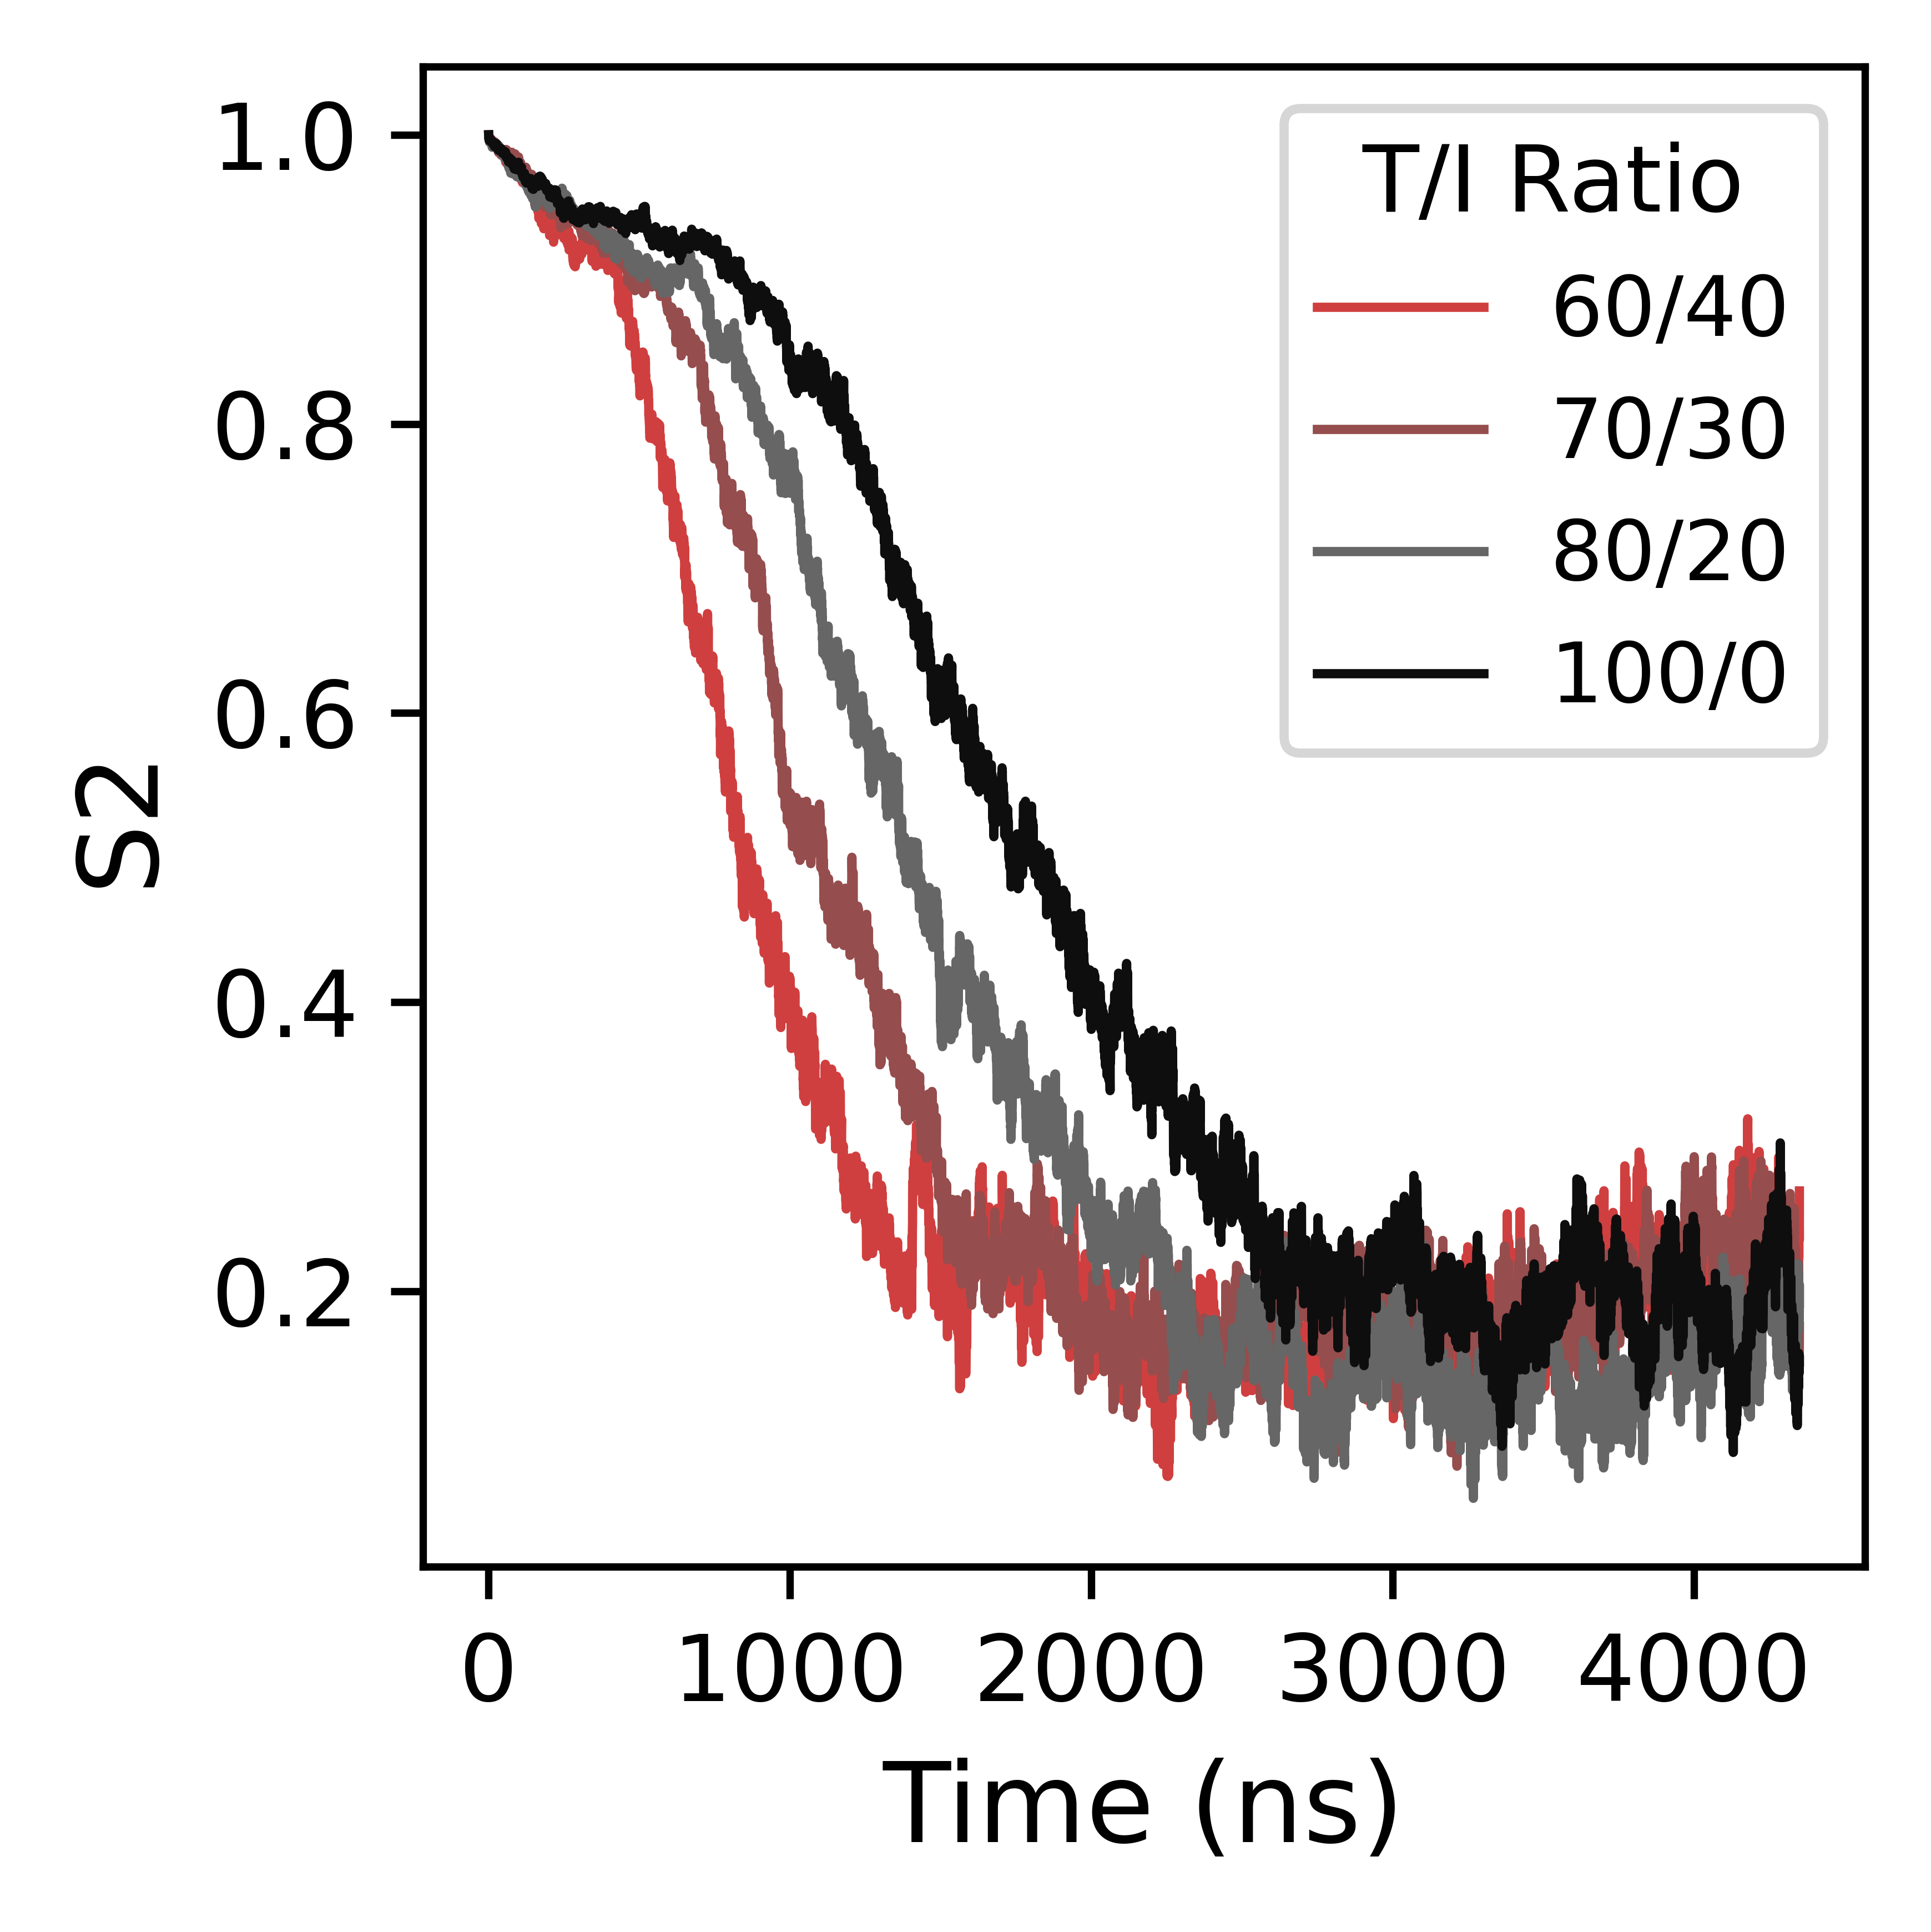

In [6]:
fig = plt.figure()

for ti_ratio, jobs in project.find_jobs(
    {"doc.done": True, "kT_quench": kT, "cg_potentials_dir": "msibi-deep", "n_steps": 5e9
    }).groupby("ekk_weight"):
    
    for job in jobs:
        if ti_ratio == 0.60:
            label="60/40"
        elif ti_ratio == 0.70:
            label="70/30"
        elif ti_ratio == 0.80:
            label="80/20"
        elif ti_ratio == 1.0:
            label="100/0"
        nem_order = np.loadtxt(job.fn("nem_order.txt"))
        ns = frames_to_ns(job.doc.real_timestep, range(0, len(nem_order)), job.sp.gsd_write)
        plt.plot(ns, nem_order, label=label, c=color_dict[ti_ratio])
        #print(job.ws)
        
plt.legend(title="T/I Ratio", fontsize=9)

plt.xlabel("Time (ns)")
plt.ylabel("S2")
plt.tight_layout()
plt.savefig(f"s2-order-parm-decay-{kT}kT.png")
plt.show()

# End-to-End Distances

In [14]:
!pwd

/home/erjank_project/chrisjones/pekk-msibi-final/notebooks


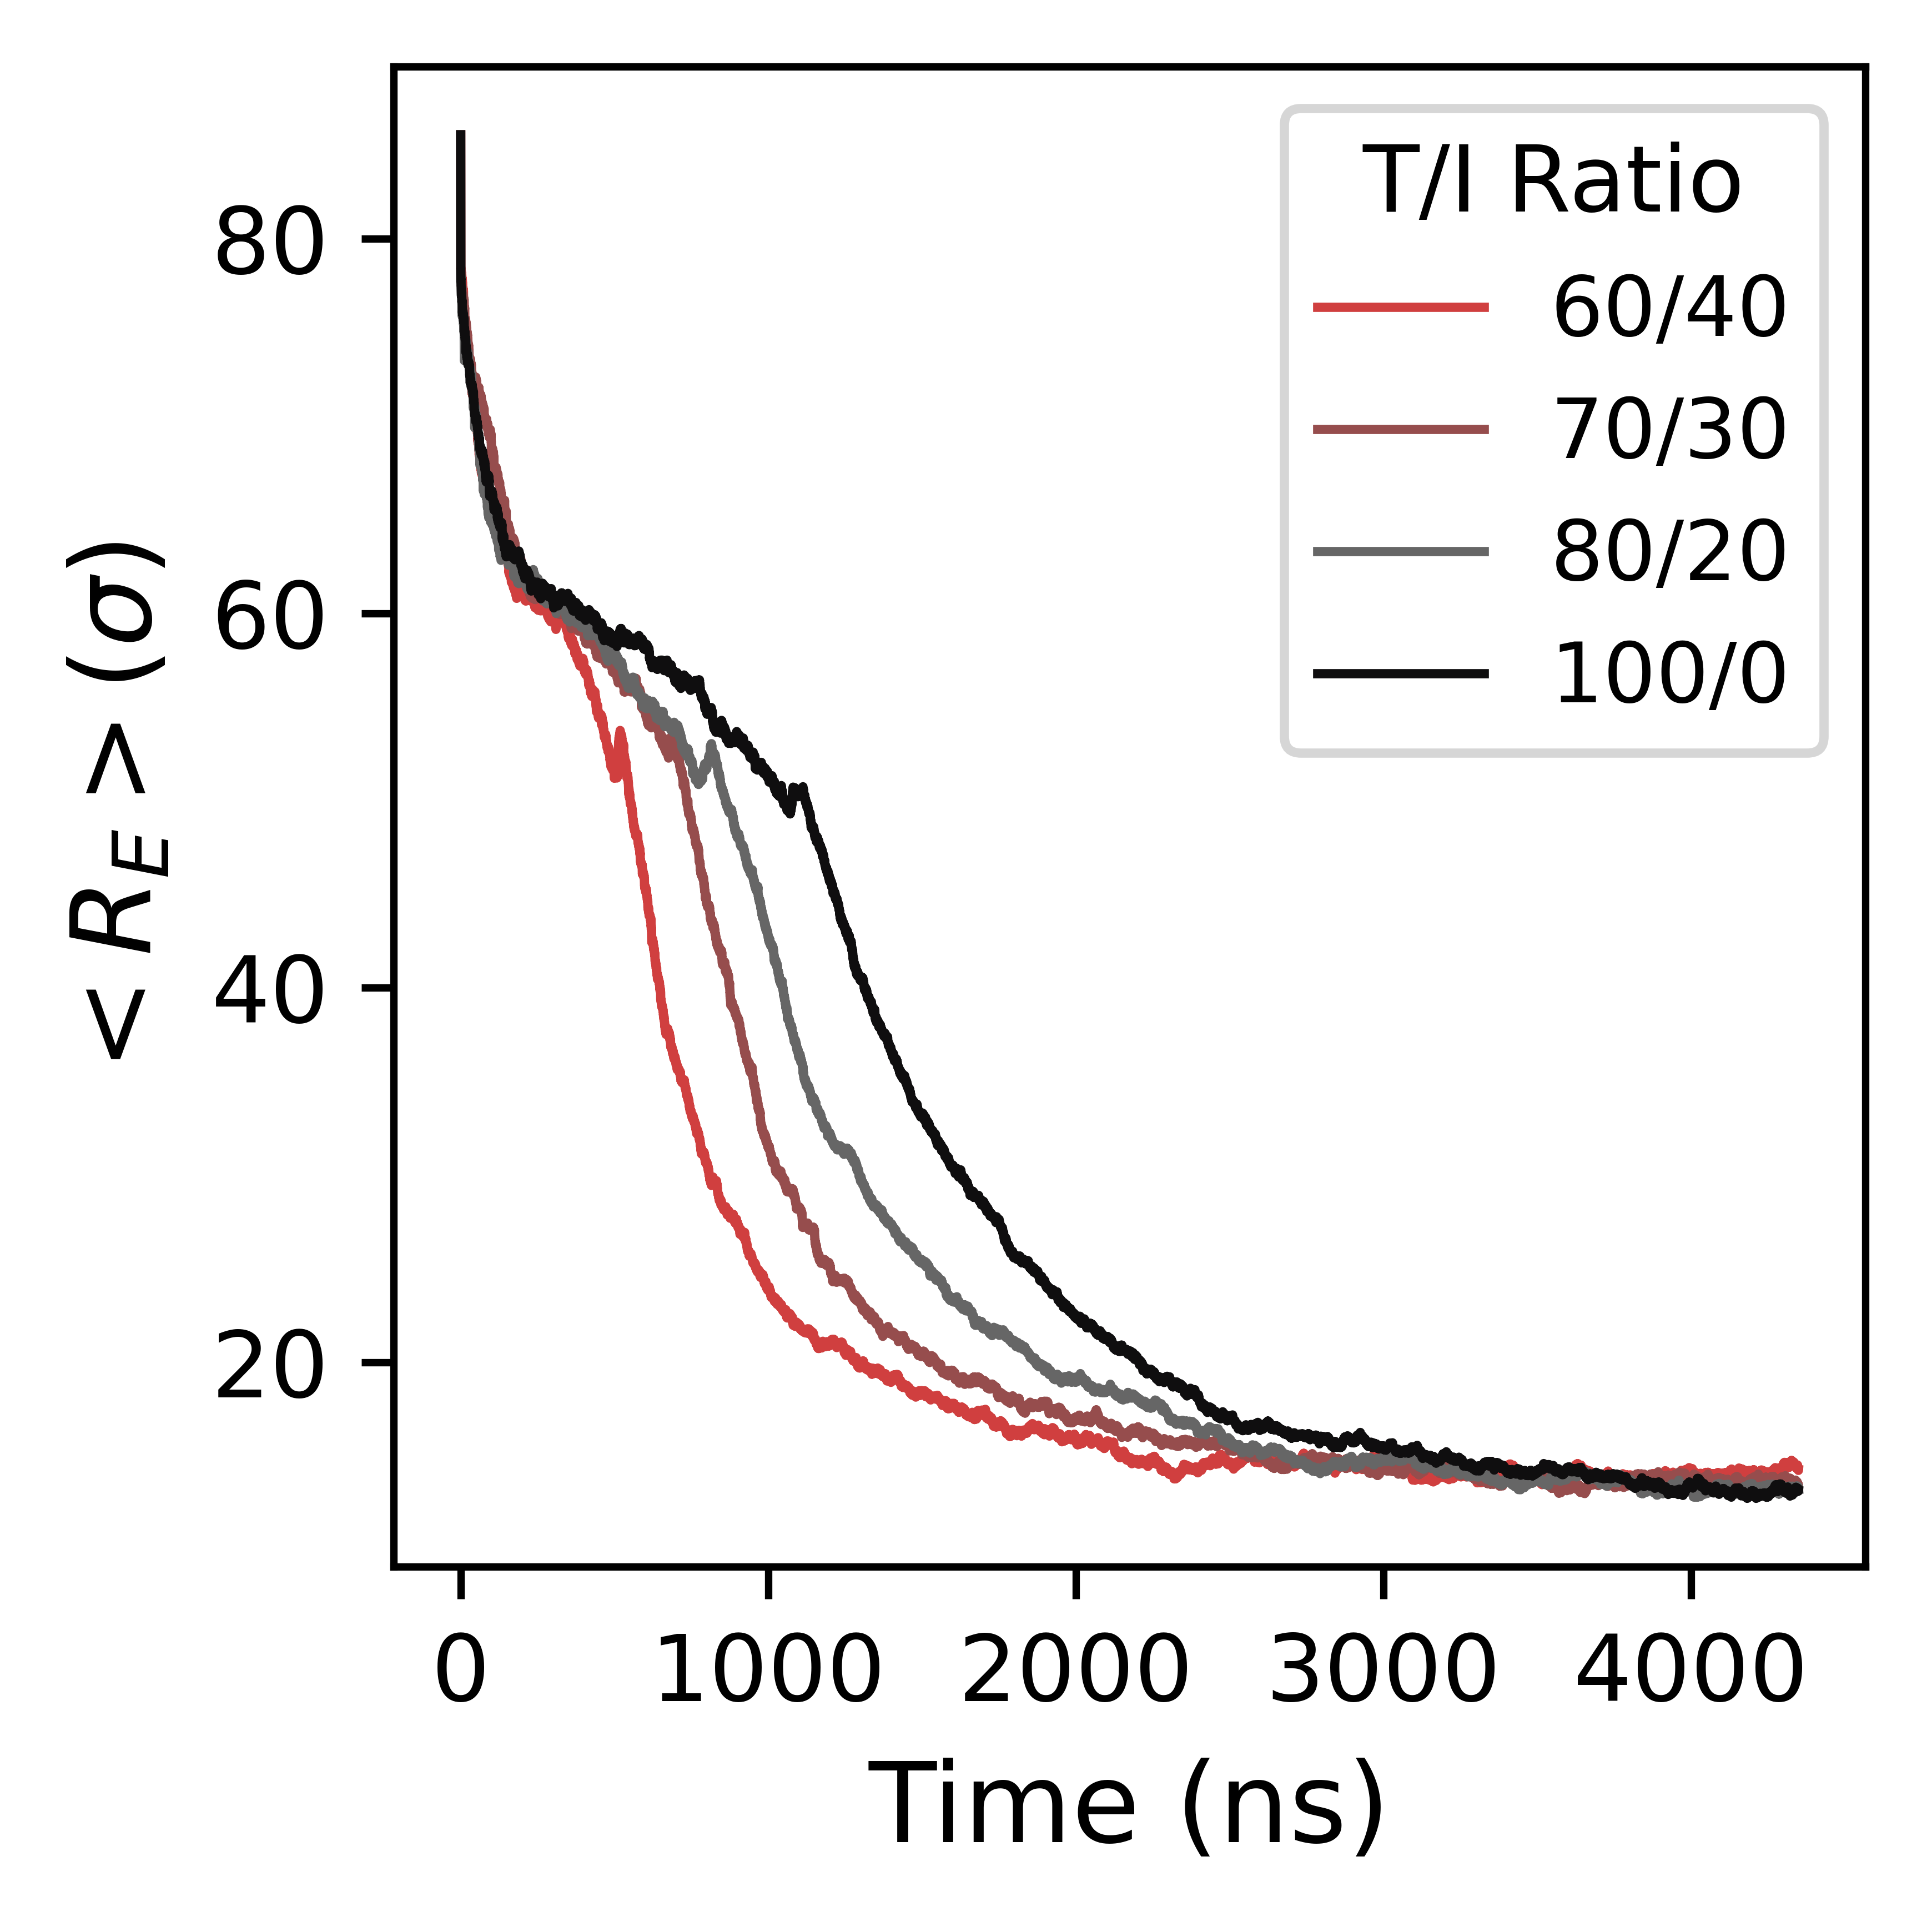

In [8]:
fig = plt.figure()

for ti_ratio, jobs in project.find_jobs(
    {"doc.done": True, "kT_quench": kT, "cg_potentials_dir": "msibi-deep", "n_steps": 5e9
    }).groupby("ekk_weight"):            
    for job in jobs:
        if ti_ratio == 0.60:
            label="60/40"
        elif ti_ratio == 0.70:
            label="70/30"
        elif ti_ratio == 0.80:
            label="80/20"
        elif ti_ratio == 1.0:
            label="100/0"
        re_means = np.loadtxt(job.fn("re_means.txt"))
        re_stds = np.loadtxt(job.fn("re_stds.txt"))
        ns = frames_to_ns(job.doc.real_timestep, range(0, len(re_means)), job.sp.gsd_write)
        plt.plot(ns, re_means, label=label, c=color_dict[ti_ratio])
        #plt.errorbar(x=ns, y=re_means, yerr=re_stds, marker="o")
        
plt.legend(title="T/I Ratio", fontsize=9)

plt.xlabel("Time (ns)")
plt.ylabel("$<R_E> (\sigma)$")
#plt.xlim(0, 500)
plt.tight_layout()
#plt.savefig(f"end-to-end-decay-{kT}kT.png")
plt.show()

# Mean Square Displacement:

In [ ]:
ua_results = {}
chunk_size=200
start_frame = 500
end_frame = 2000 - chunk_size
n_samples = 20

for ti_ratio, jobs in project.find_jobs(
    {"doc.done": True, "kT_quench": kT, "cg_potentials_dir": "msibi-deep", "n_steps": 5e9
    }).groupby("ekk_weight"):  
    job = list(jobs)[0]
    with gsd.hoomd.open(job.fn("components.gsd")) as traj:
        end_frame = len(traj) - chunk_size
        random_starts = np.random.randint(start_frame, end_frame, n_samples)
        
    window_slopes = []
    steps_per_frame = job.doc.steps_per_frame
    ts = job.doc.real_timestep * 1e-15
    ts_frame = steps_per_frame * ts
    
    for i in random_starts:
        msd = msd_from_gsd(
            gsdfile=job.fn("components.gsd"),
            start=int(i),
            stop=int(i) + chunk_size,
            atom_types="all",
            msd_mode="direct"
        )
        
        msd_data = np.copy(msd.msd)
        msd_data *= 3.39**2 * 1e-20
        time = np.arange(0, chunk_size, 1) * ts_frame
        mid_chunk = msd_data[len(msd_data)//4:-len(msd_data)//4]
        mid_chunk_time = time[len(time)//4:-len(time)//4]
        window_slopes.append((mid_chunk[-1] - mid_chunk[0])/(mid_chunk_time[-1] - mid_chunk_time[0]))
        
    ua_results[job.doc.T_SI - 273] = [np.mean(window_slopes), np.std(window_slopes)]
    job.doc.D = np.mean(window_slopes)
    job.doc.D_std = np.std(window_slopes)
    job.doc.T_celsius = job.doc.T_SI - 273

In [25]:
fig = plt.figure()

for ti_ratio, jobs in project.find_jobs(
    {"doc.done": True, "kT_quench": 2.0, "cg_potentials_dir": "msibi-shallow"
    }).groupby("ekk_weight"):
        for job in jobs:
            msd = msd_from_gsd(
                gsdfile=job.fn("sim_traj.gsd"),
                start=0,
                stop=-1,
                atom_types="all",
                msd_mode="direct"
            )
            ns = frames_to_ns(job.doc.real_timestep, range(0, len(msd.msd)), job.sp.gsd_write)
            data = np.vstack([ns, msd.msd])
            np.savetxt(fname=job.fn("msd.txt"), X=data.T, delimiter=",")
            print(job)


684609f96c9f66b53bb8cf16b9dabdbb
ffebf83348486c231726975386c8cc67
16682b9ef596ff381b625c9c66eb9036
082c6e91cce5471ac200cd69f128d5ef


<Figure size 3600x3600 with 0 Axes>

In [55]:
def line(power, x, b=0):
    return x**(power) + b

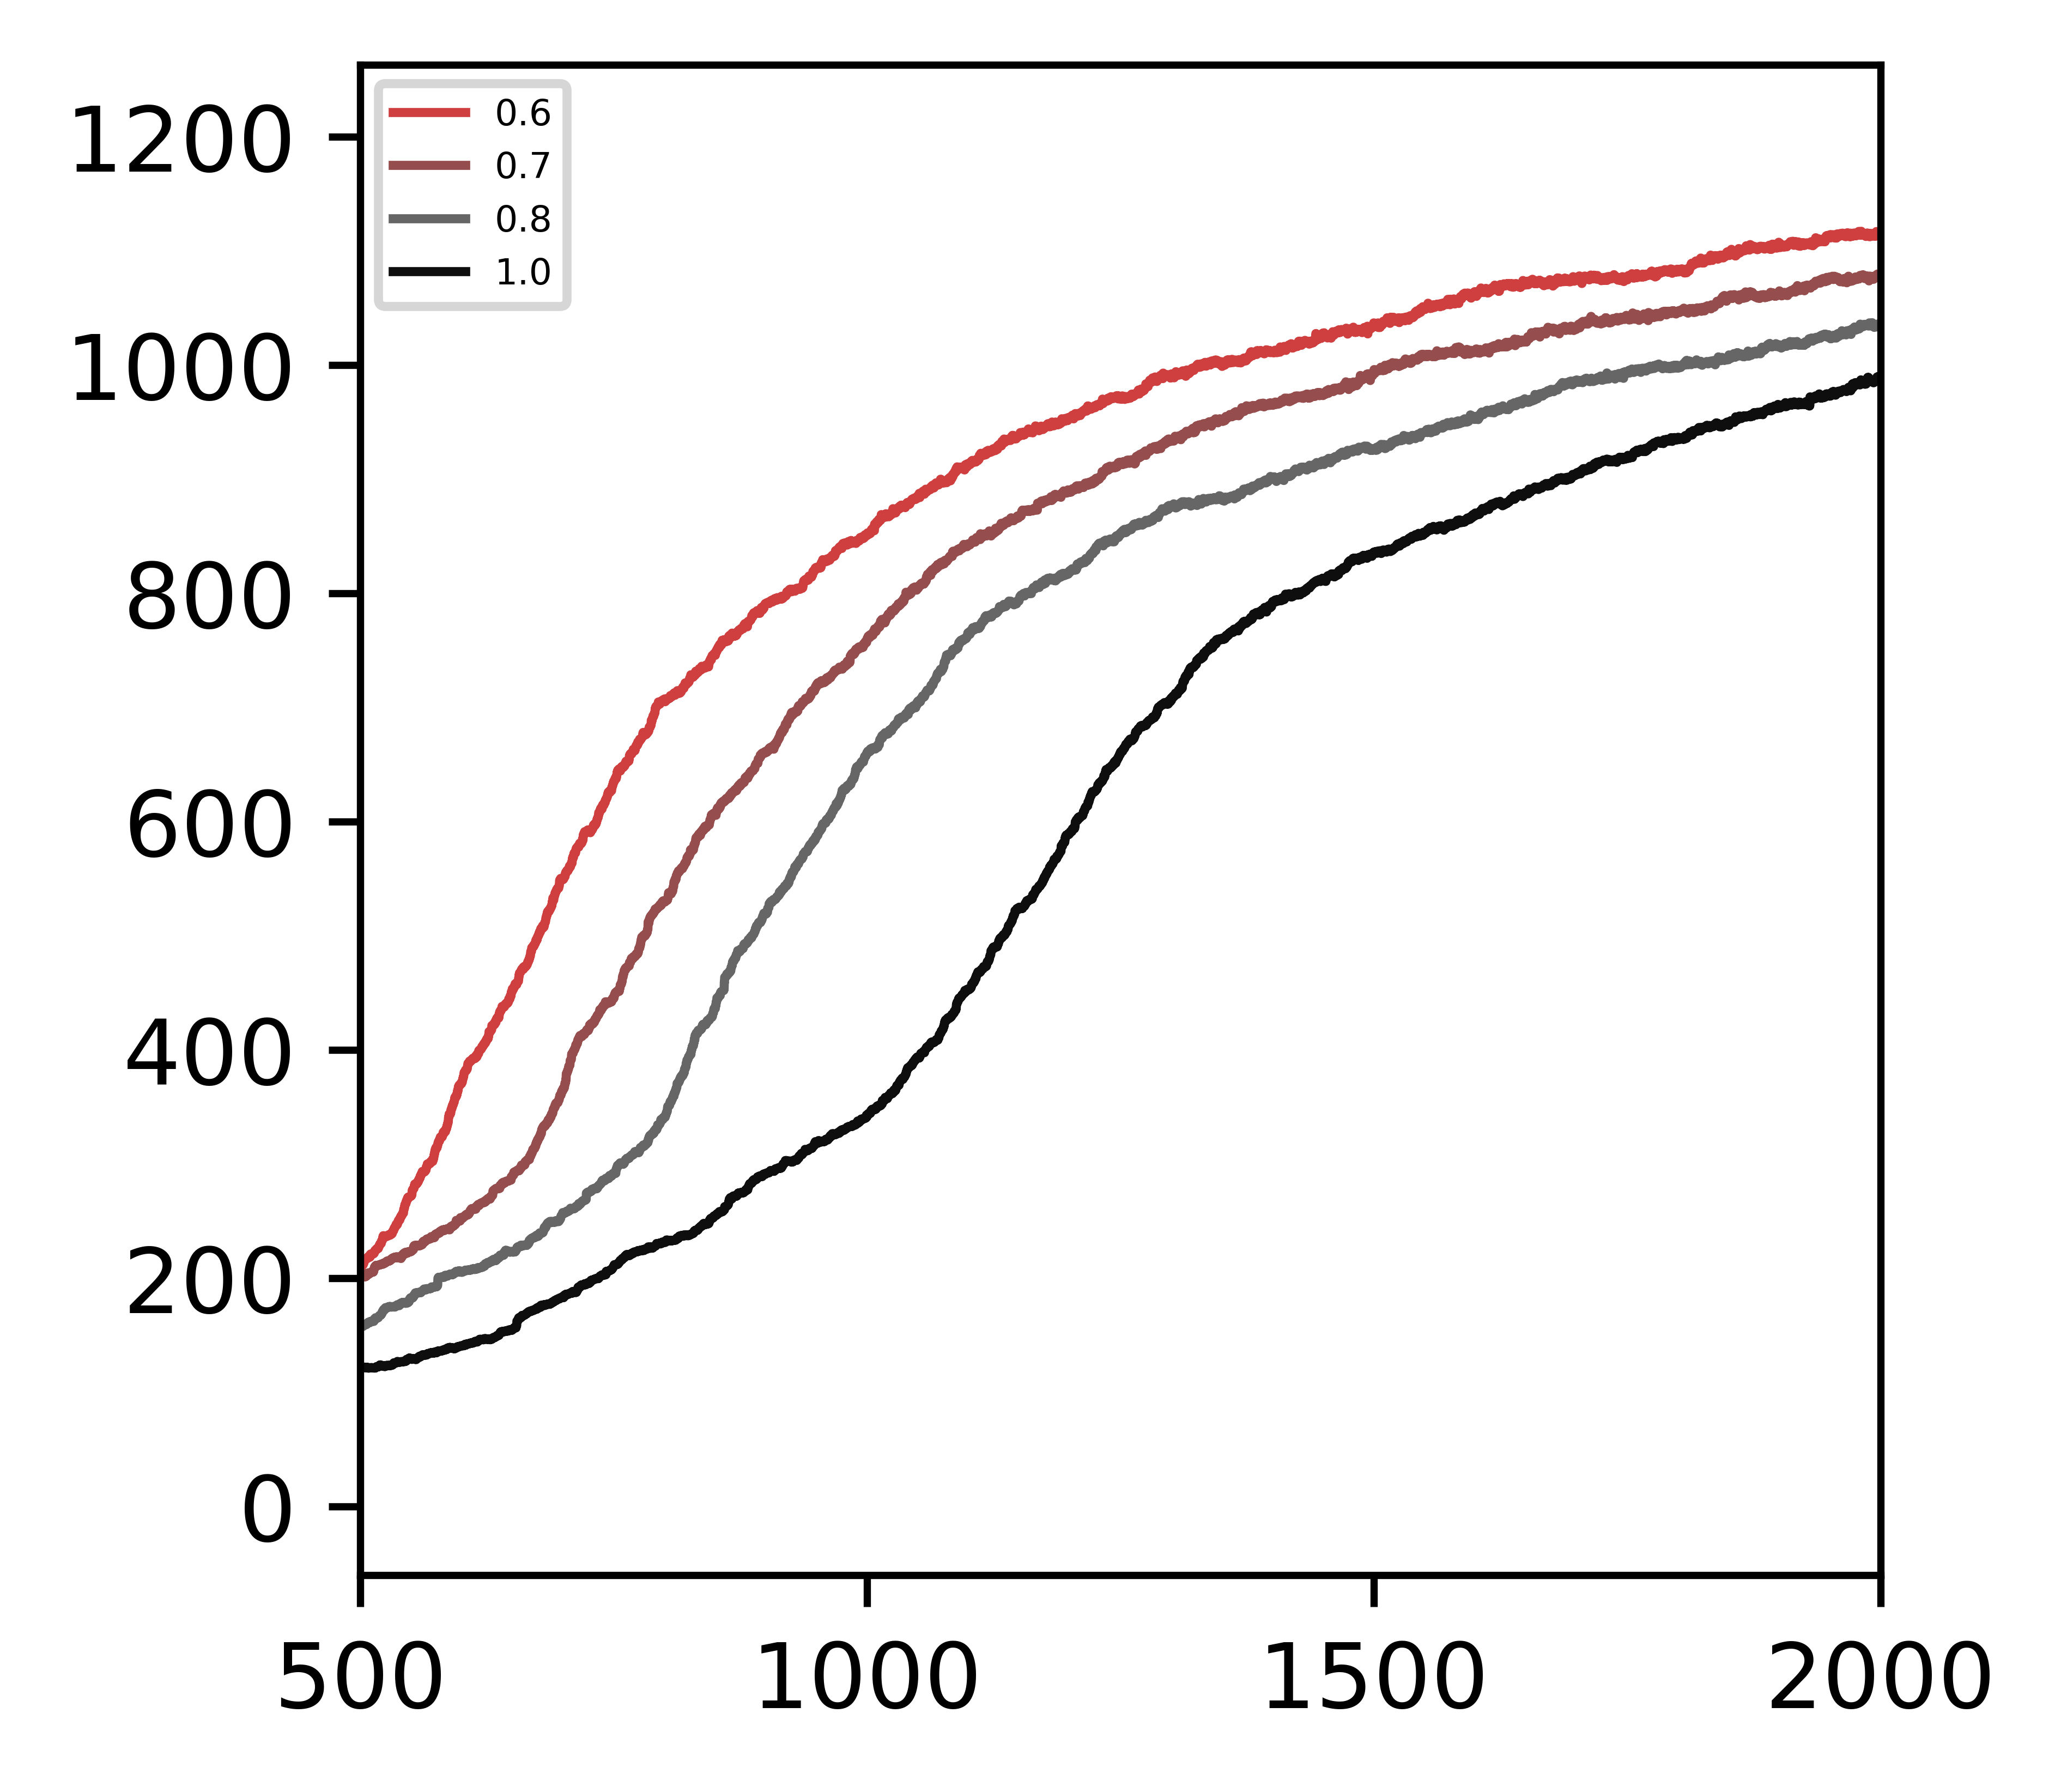

In [69]:
fig = plt.figure()

for ti_ratio, jobs in project.find_jobs(
    {"doc.done": True, "kT_quench": 2.0, "cg_potentials_dir": "msibi-deep"
    }).groupby("ekk_weight"):
        for job in jobs:
            msd = np.loadtxt(job.fn("msd.txt"), delimiter=",")
            plt.plot(msd[:,0], msd[:,1], label=ti_ratio, c=color_dict[ti_ratio])

plt.legend()
plt.xlim(500, 2000)
#plt.ylim(0, 1000)
plt.show()

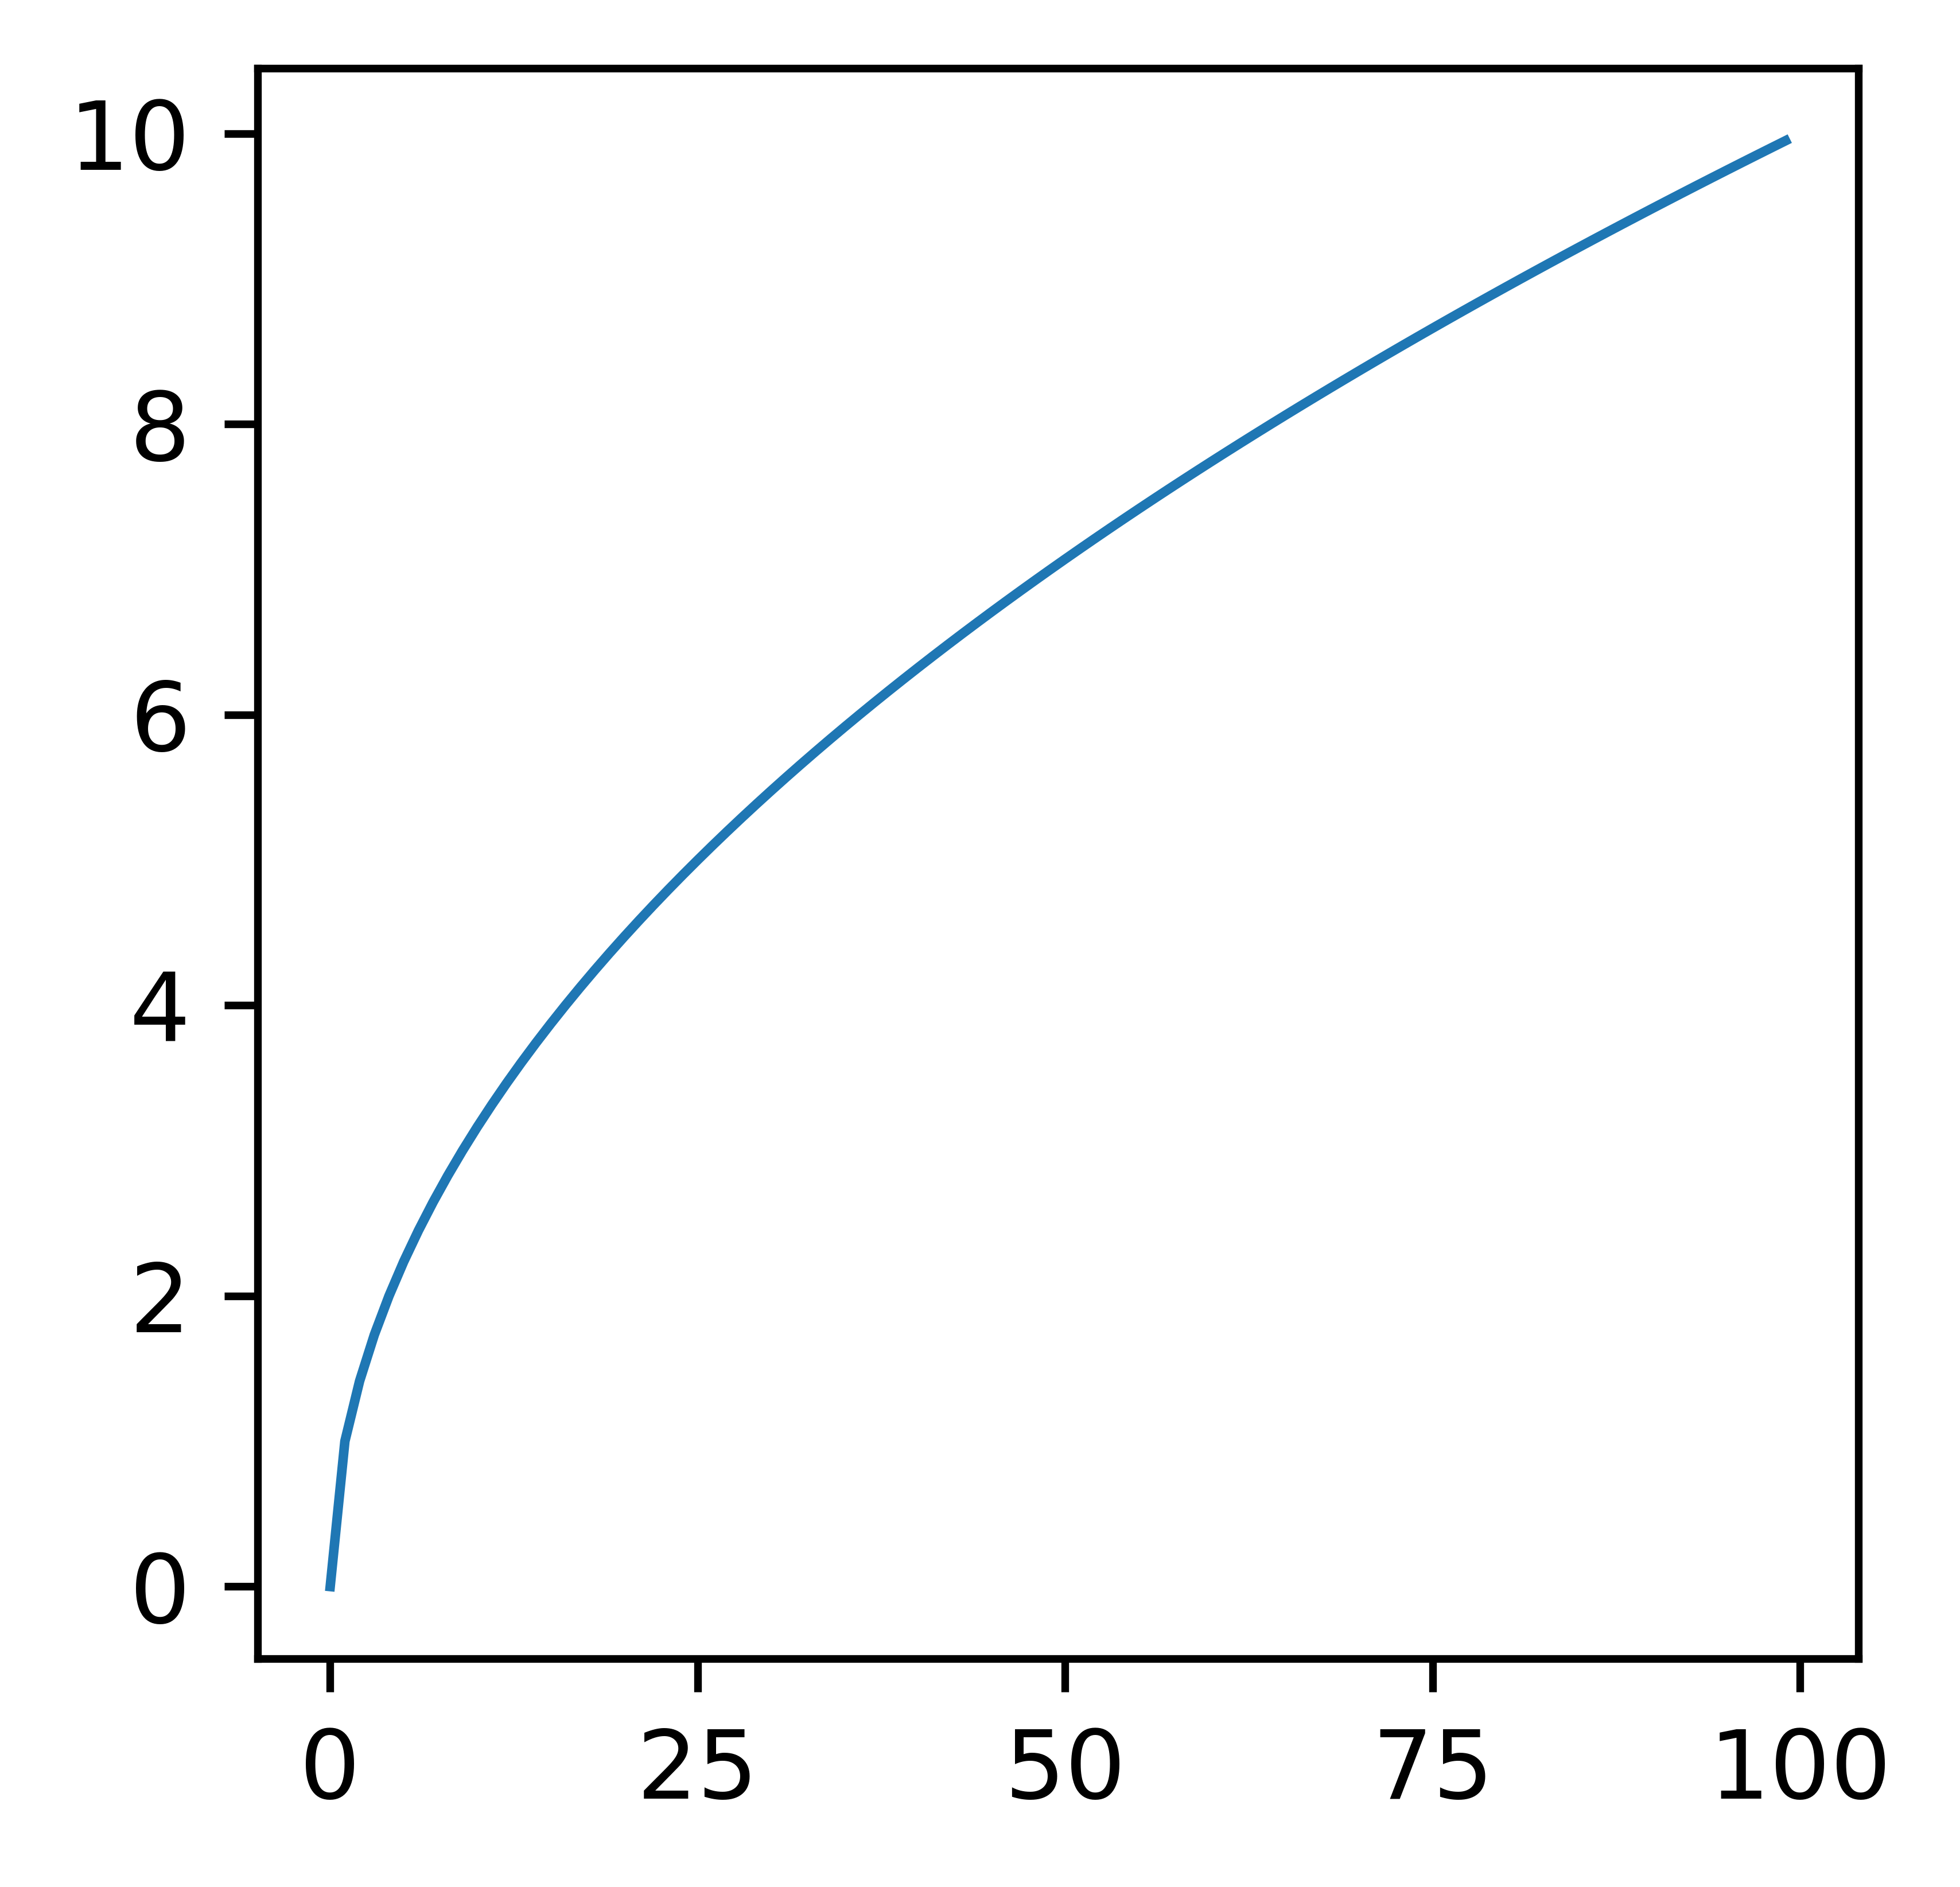

In [56]:
plt.plot(np.arange(0, 100), line(0.5, np.arange(0, 100)))

In [14]:
data = np.vstack([ns, msd.msd])

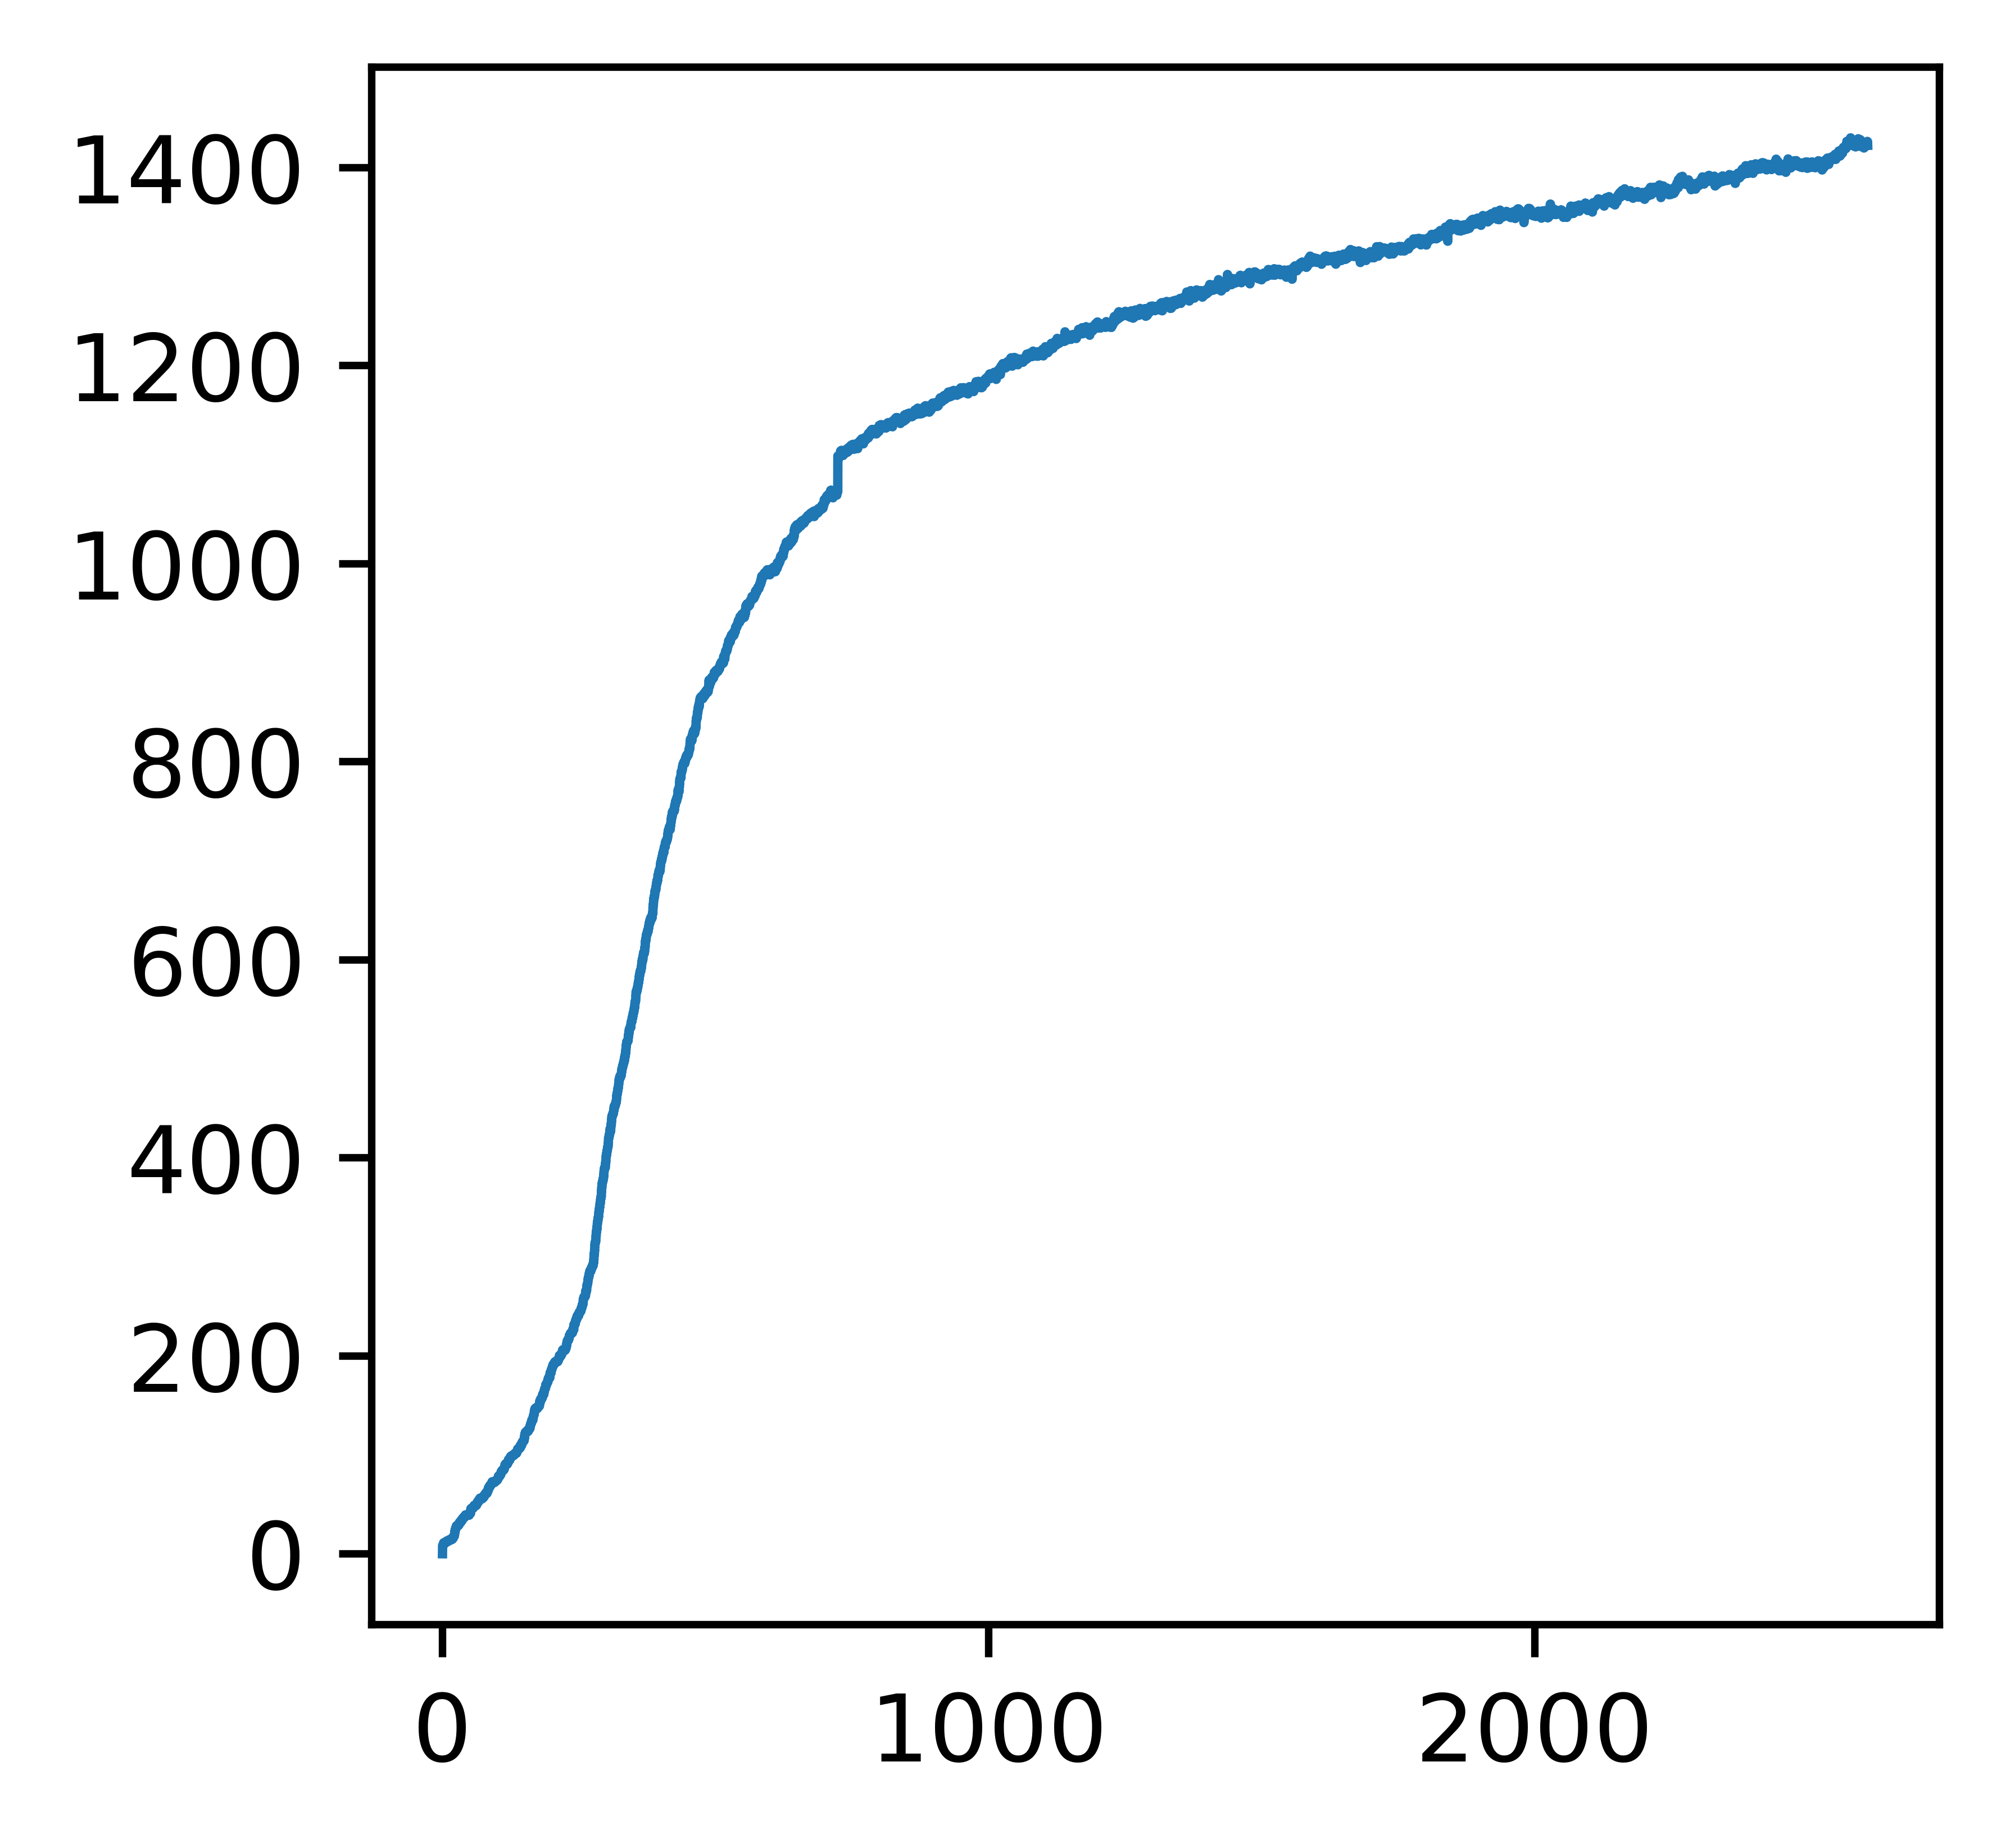

In [17]:
plt.plot(data.T[:,0], data.T[:,1])

In [16]:
data.T

array([[0.00000000e+00, 0.00000000e+00],
       [1.74000000e-01, 8.31220150e+00],
       [3.48000000e-01, 8.31220150e+00],
       ...,
       [2.60947800e+03, 1.42513684e+03],
       [2.60965200e+03, 1.42513684e+03],
       [2.60982600e+03, 1.42227100e+03]])

In [12]:
msd.msd.shape


(15000,)

In [13]:
ns.shape

(15000,)

0.6 398.98
0.7 462.67
0.8 467.02
1.0 482.33


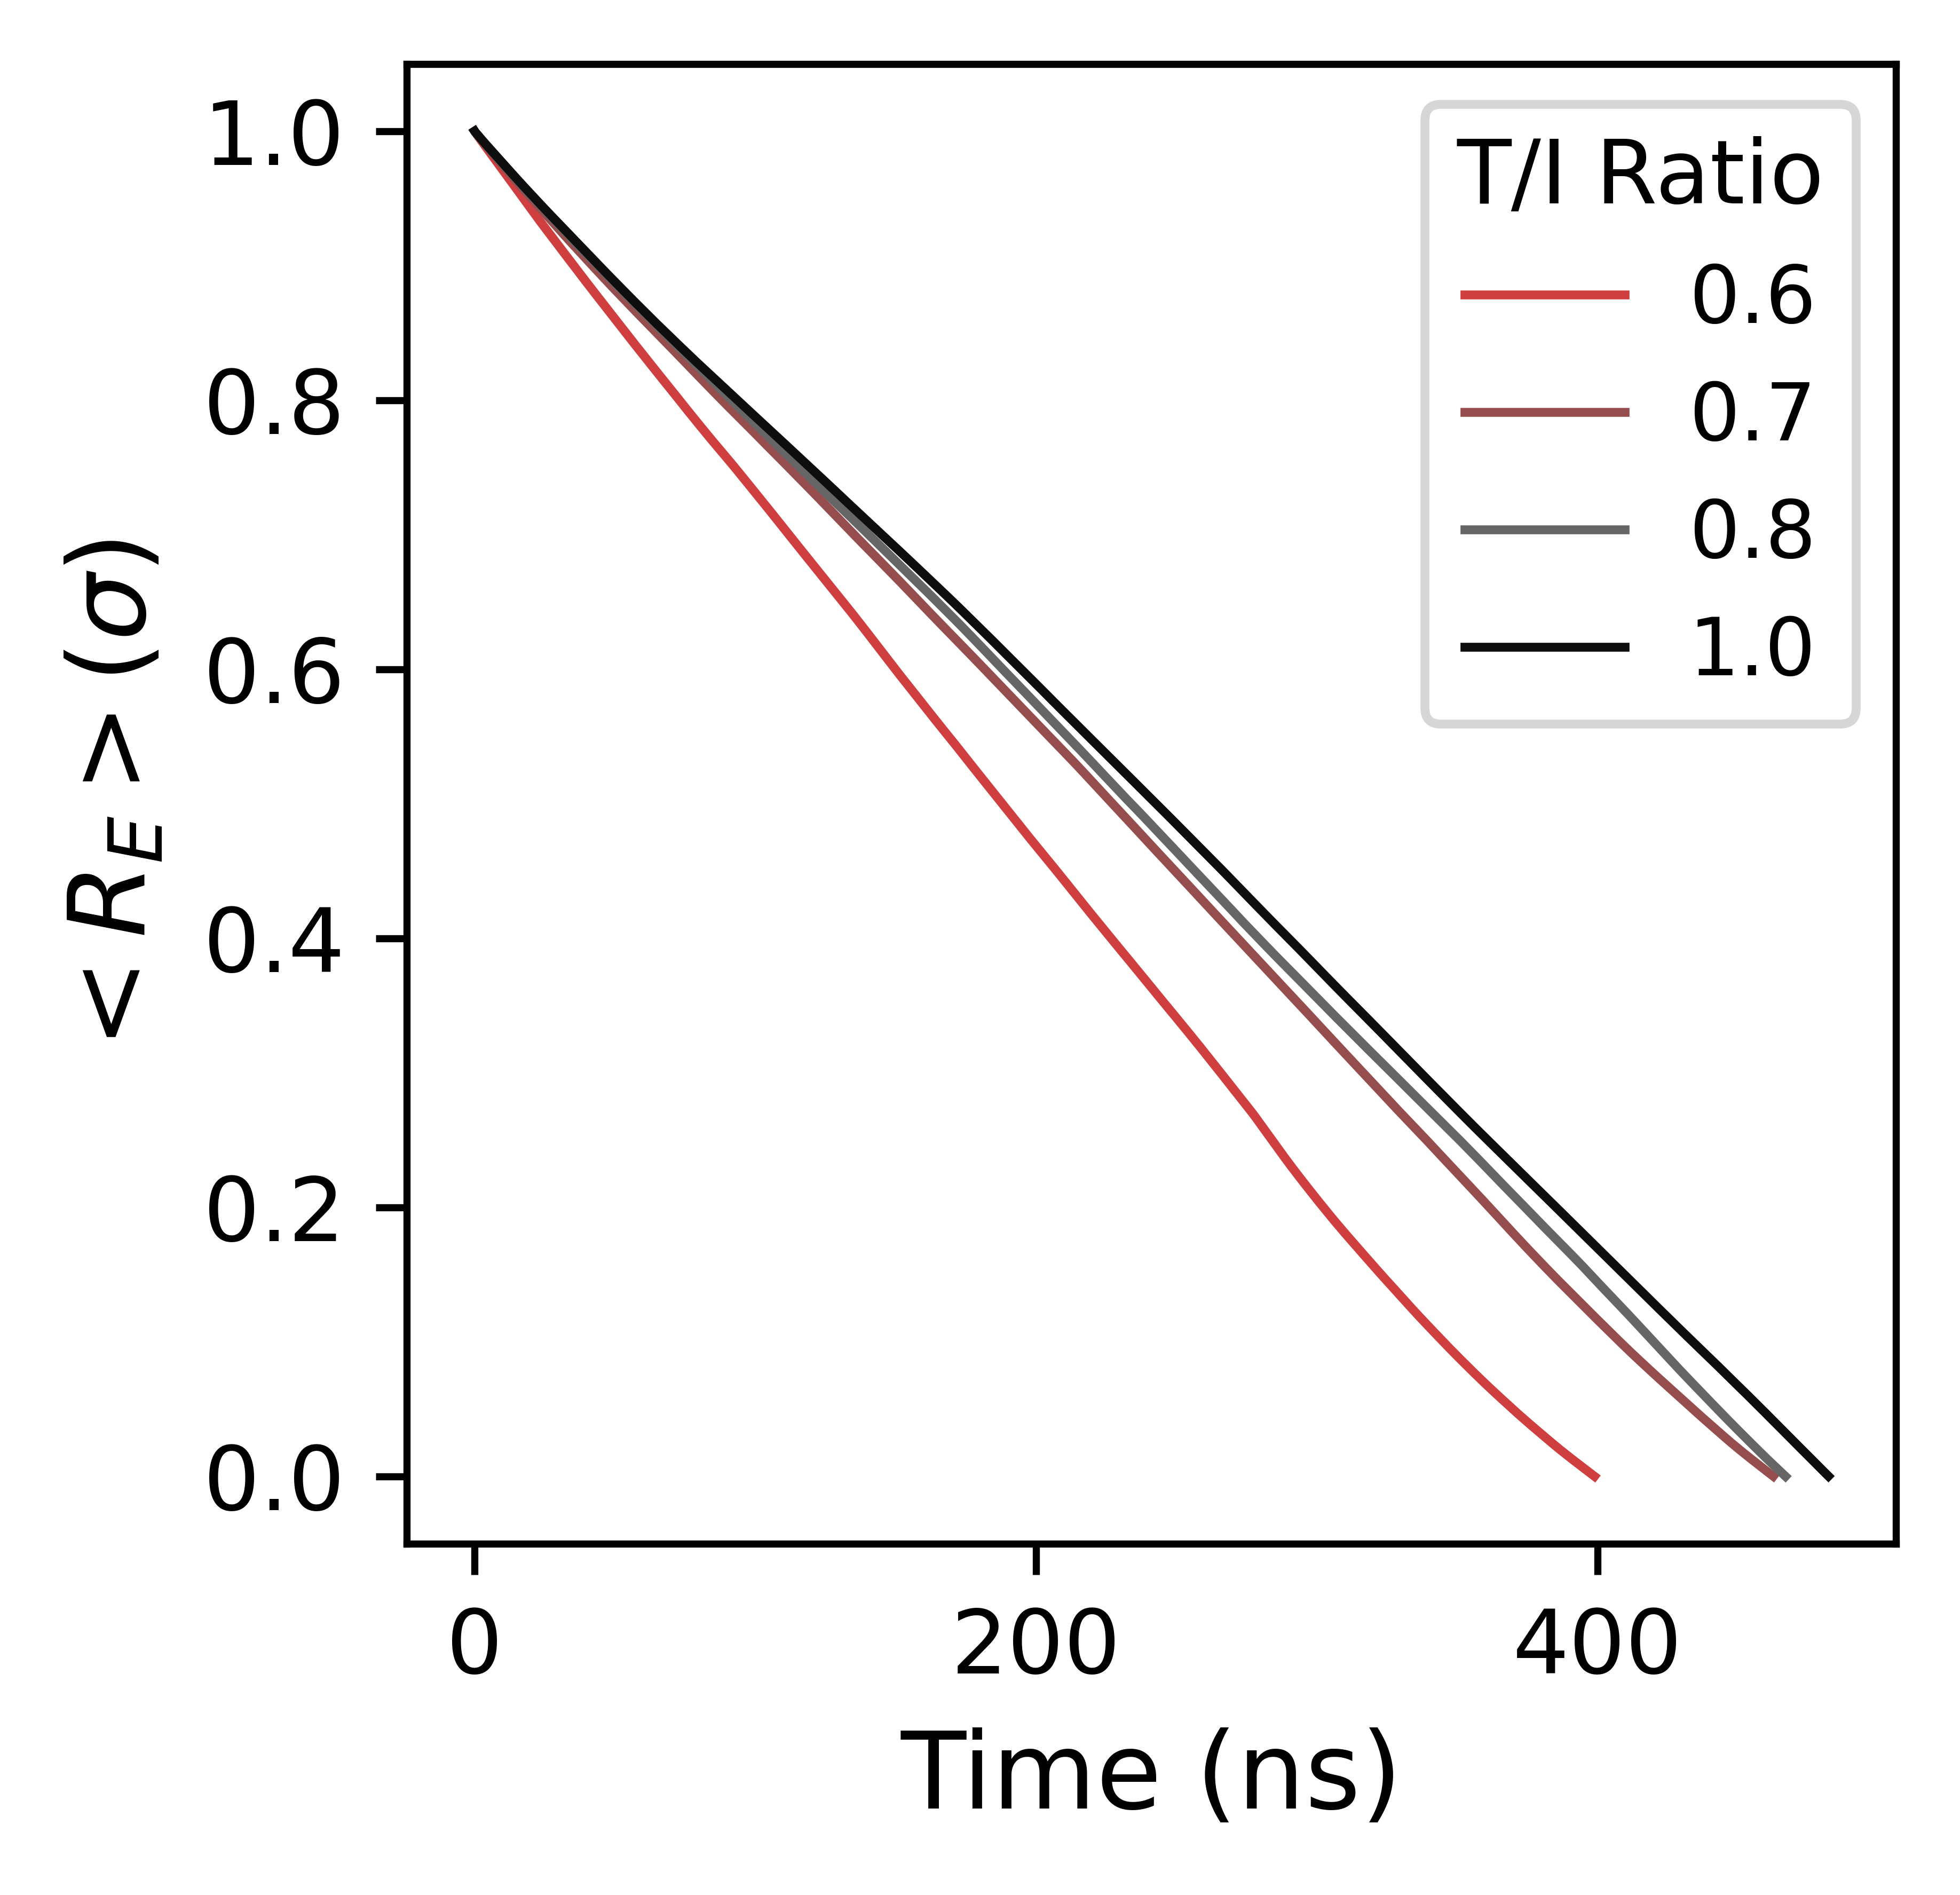

In [6]:
fig = plt.figure()

for ti_ratio, jobs in project.find_jobs(
    {"doc.done": True, "kT_quench": 2.5, "cg_potentials_dir": "msibi-deep"
    }).groupby("ekk_weight"):
    
    for job in jobs:
        re_means = np.loadtxt(job.fn("re_means.txt"))
        decorr = autocorr1D(re_means)
        ns = frames_to_ns(job.doc.real_timestep, range(0, len(decorr)), job.sp.gsd_write)
        pos_indices = np.where(decorr >= 0)[0]
        plt.plot(ns[pos_indices], decorr[pos_indices], label=ti_ratio, c=color_dict[ti_ratio])
        print(ti_ratio, round(ns[pos_indices][-1], 2))
        
plt.legend(title="T/I Ratio", fontsize=9)

plt.xlabel("Time (ns)")
plt.ylabel("$<R_E> (\sigma)$")
plt.show()

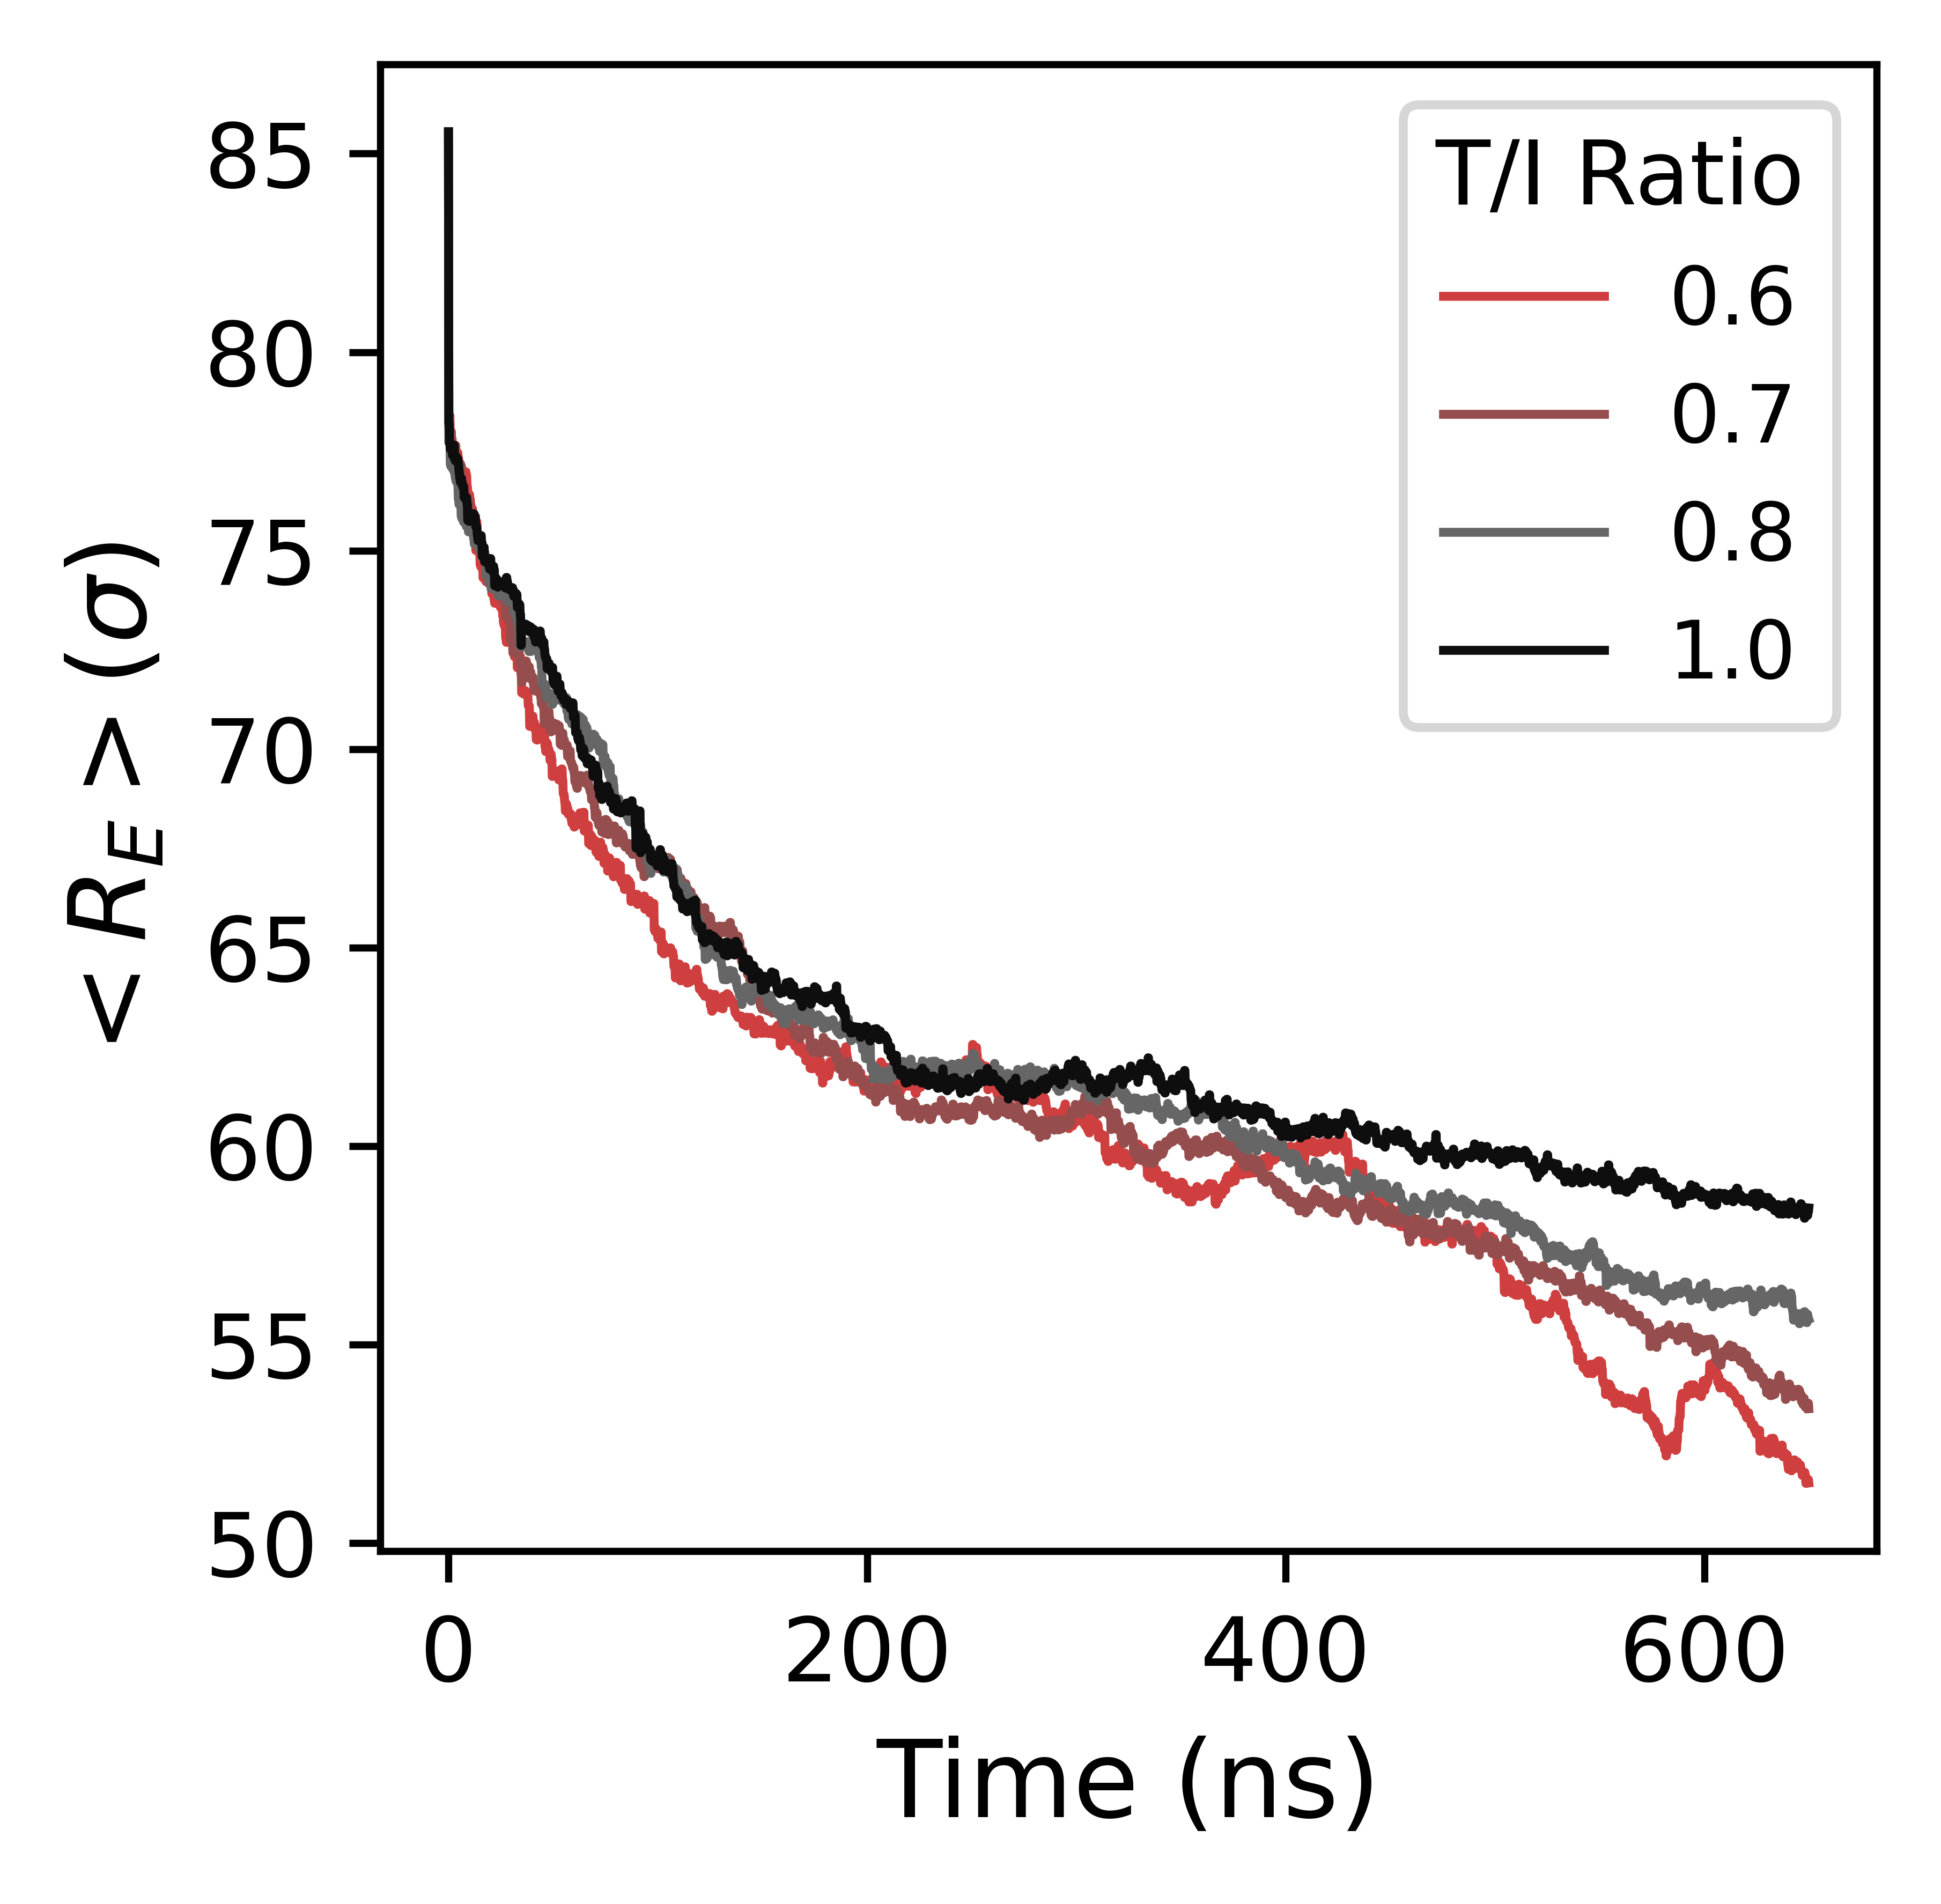

<Figure size 3600x3600 with 0 Axes>

In [61]:
fig = plt.figure()

for ti_ratio, jobs in project.find_jobs(
    {"doc.done": True, "kT_quench": 2.0, "cg_potentials_dir": "msibi-deep"
    }).groupby("ekk_weight"):
    
    for job in jobs:
        re_means = np.loadtxt(job.fn("re_means.txt"))
        ns = frames_to_ns(job.doc.real_timestep, range(0, len(re_means)), job.sp.gsd_write)
        inds = np.where(ns < 650)[0]
        plt.plot(ns[inds], re_means[inds], label=ti_ratio, c=color_dict[ti_ratio])
        
plt.legend(title="T/I Ratio", fontsize=9)

plt.xlabel("Time (ns)")
plt.ylabel("$<R_E> (\sigma)$")
plt.show()
plt.savefig("end-to-end-decay.png")

In [52]:
print(ns[-5:])

[2606.4504 2606.4678 2606.4852 2606.5026 2606.52  ]


In [ ]:
fig = plt.figure()

count = 0
for ti_ratio, jobs in project.find_jobs(
    {"doc.done": True, "kT_quench": 2.0, "cg_potentials_dir": "msibi-deep"
    }).groupby("ekk_weight"):
    
    for job in jobs:
        with gsd.hoomd.open(job.fn("sim_traj.gsd")) as traj:
            traj_len = len(traj)
        data = np.genfromtxt(job.fn("sim_traj.txt"), names=True)
        pressure = data["mdcomputeThermodynamicQuantitiespressure"]
        pe = data["mdcomputeThermodynamicQuantitiespotential_energy"]
        print(len(pe)/traj_len)
        ns = frames_to_ns(job.doc.real_timestep, range(0, len(pe)), 160000/6)
        #plt.plot(ns, pe + 50000*count, label=ti_ratio, c=color_dict[ti_ratio])
        plt.plot(ns, pressure + 1*count, label=ti_ratio, c=color_dict[ti_ratio])
        count += 1

#plt.ylim(-200000, 100000)
plt.ylim(-1, 8)
plt.legend(title="T/I Ratio", fontsize=9)
plt.xlabel("Time (ns)")
plt.ylabel("Pressure")
plt.show()

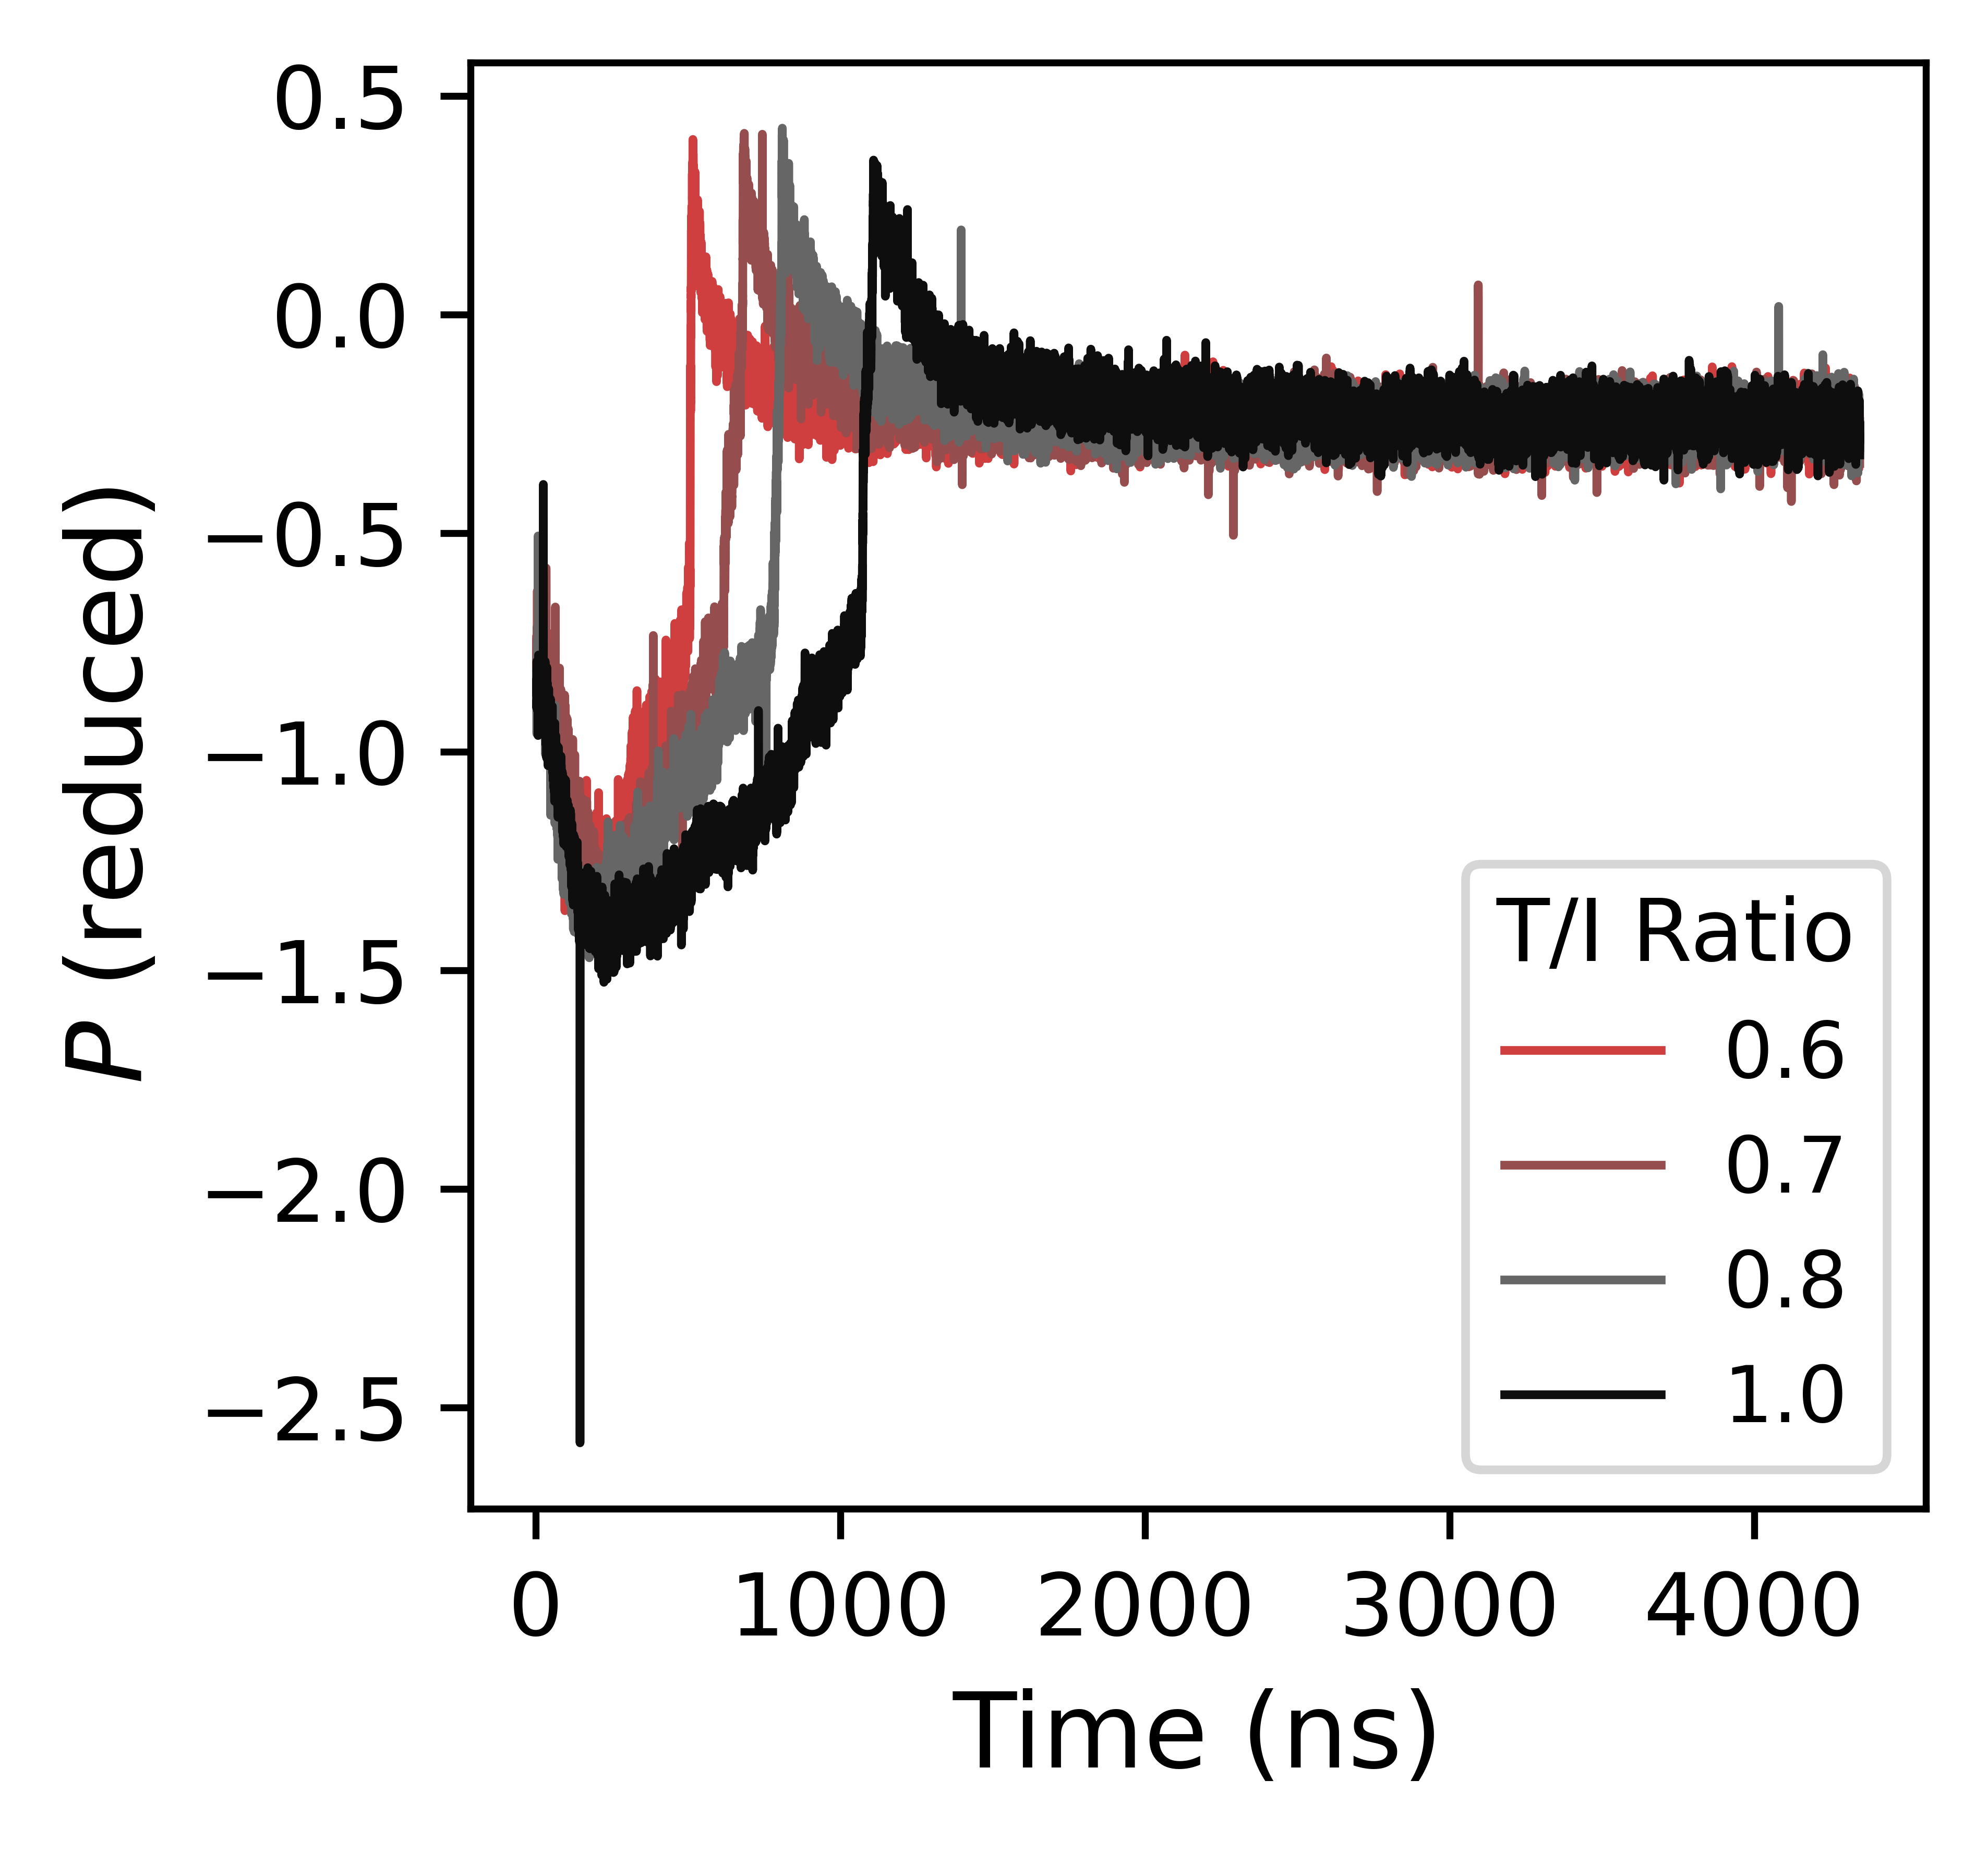

In [19]:
fig = plt.figure()

count = 0
for ti_ratio, jobs in project.find_jobs(
    {"doc.done": True, "kT_quench": kT, "cg_potentials_dir": "msibi-deep", "n_steps": 5e9
    }).groupby("ekk_weight"): 
    
    for job in jobs:
        data = np.genfromtxt(job.fn("sim_traj.txt"), names=True)
        pressure = data["mdcomputeThermodynamicQuantitiespressure"][200:]
        pe = data["mdcomputeThermodynamicQuantitiespotential_energy"]
        pressure = savitzky_golay(pressure, order=1, window_size=11)
        pe = savitzky_golay(pe, order=1, window_size=11)
        ns = frames_to_ns(job.doc.real_timestep, range(0, len(pressure)), job.sp.log_write)
        plt.plot(ns[200:], -pressure[200:], label=ti_ratio, c=color_dict[ti_ratio])
        #plt.plot(ns[200:], pe[200:], label=ti_ratio, c=color_dict[ti_ratio])

        count += 0

plt.legend(title="T/I Ratio", fontsize=9, ncol=1)
#plt.ylim(-0.5, 1.6)
plt.xlabel("Time (ns)")
plt.ylabel("$P$ (reduced)")
plt.show()

In [10]:
fig = plt.figure()

count = 0
for ti_ratio, jobs in project.find_jobs(
    {"doc.done": True, "kT_quench": kT, "cg_potentials_dir": "msibi-deep", "n_steps": 5e9
    }).groupby("ekk_weight"): 
    
    for job in jobs:
        data = np.genfromtxt(job.fn("sim_traj.txt"), names=True)
        pe = data["mdcomputeThermodynamicQuantitiespotential_energy"][200:] / job.doc.n_particles
        pe = savitzky_golay(pe, order=1, window_size=11)
        ns = frames_to_ns(job.doc.real_timestep, range(0, len(pe)), job.sp.log_write)
        plt.plot(ns, pe + 2*count, label=ti_ratio, c=color_dict[ti_ratio])
        count += 0

plt.legend(title="T/I Ratio", fontsize=9, ncol=1)
#plt.ylim(-0.5, 1.6)
plt.xlabel("Time (ns)")
plt.ylabel("$P$ (reduced)")
plt.show()

AttributeError: 'n_particles'

<Figure size 3600x3600 with 0 Axes>

In [67]:
7*np.log(7)

13.621371043387192

In [48]:
for job in project:
    with gsd.hoomd.open(job.fn("sim_traj.gsd")) as traj:
        snap = traj[0]
        job.doc.n_particles = snap.particles.N

/home/chrisjones4/miniconda3/envs/polybinder2/lib/python3.9/site-packages/signac/synced_collections/numpy_utils.py:46: NumpyConversionWarning: Any numpy types provided will be transparently converted to the closest base Python equivalents.
  warnings.warn(NUMPY_CONVERSION_WARNING, NumpyConversionWarning)


In [49]:
job.doc.n_particles

12000

In [37]:
ql2.order

0.0004923659726046026

# Single Chain Relaxation:

In [ ]:
#project = signac.get_project("../coarse-grain-sims/ti_chain_relaxation/polybinder-flow/")
project = signac.get_project("../coarse-grain-sims/ti_chain_relaxation/single-chain/polybinder-flow/")

In [ ]:
length = 120
kT = 7.0
pot = "msibi-deep"
for weight, job in project.find_jobs({"kT_quench": kT, "cg_potentials_dir": pot, "polymer_lengths": [length]}).groupby("ekk_weight"):
    job = list(job)[0]
    print(job.id)
    stop = -1
    start=0
    re_array, _re_mean, re_std, vectors = end_to_end_distance(
        job.fn("sim_traj.gsd"), head_index=0, tail_index=-1, start=start, stop=stop
    )
    plt.plot(_re_mean, label=weight)
    #auto_corr = autocorr1D(re_array)
    #smoothed = savitzky_golay(auto_corr, window_size=31, order=1)
    #plt.plot(auto_corr, color=color_dict[weight], alpha=0.3)
    #plt.plot(smoothed, label=weight, color=color_dict[weight])
    #plt.hlines(y=0, xmin=0, xmax=(stop-start)/2, ls="--", colors="green")
    
plt.legend(title="T/I Ratio", fontsize=10)

In [ ]:
length = 60
kT = 7.0
pot = "msibi-deep"
for weight, job in project.find_jobs({"kT_quench": kT, "cg_potentials_dir": pot, "polymer_lengths": [length]}).groupby("ekk_weight"):
    job = list(job)[0]
    print(job.id)
    stop = -1
    start=0
    re_array, _re_mean, re_std, vectors = end_to_end_distance(
        job.fn("sim_traj.gsd"), head_index=0, tail_index=-1, start=start, stop=stop
    )
    auto_corr = autocorr1D(re_array)
    smoothed = savitzky_golay(auto_corr, window_size=31, order=1)
    #plt.plot(auto_corr, color=color_dict[weight], alpha=0.3)
    plt.plot(smoothed, label=weight, color=color_dict[weight])
    #plt.hlines(y=0, xmin=0, xmax=(stop-start)/2, ls="--", colors="green")
    
plt.legend(title="T/I Ratio", fontsize=10)

In [ ]:
length = 120
kT = 7.0
pot = "msibi-shallow"
for weight, job in project.find_jobs({"kT_quench": kT, "cg_potentials_dir": pot, "polymer_lengths": [length]}).groupby("ekk_weight"):
    job = list(job)[0]
    print(job.id)
    stop = -1
    start=0
    re_array, _re_mean, re_std, vectors = end_to_end_distance(
        job.fn("sim_traj.gsd"), head_index=0, tail_index=-1, start=start, stop=stop
    )
    auto_corr = autocorr1D(re_array)
    smoothed = savitzky_golay(auto_corr, window_size=31, order=1)
    #plt.plot(auto_corr, color=color_dict[weight], alpha=0.3)
    plt.plot(smoothed, label=weight, color=color_dict[weight])
    #plt.hlines(y=0, xmin=0, xmax=(stop-start)/2, ls="--", colors="green")
    
plt.legend(title="T/I Ratio", fontsize=10)

In [ ]:
length = 120
kT = 7.0
pot = "msibi-deep"
for weight, job in project.find_jobs({"kT_quench": kT, "cg_potentials_dir": pot, "polymer_lengths": [length]}).groupby("ekk_weight"):
    job = list(job)[0]
    print(job.id)
    stop = -1
    start=5
    rg_means, rg_std, vectors = radius_of_gyration(job.fn("sim_traj.gsd"), start=start, stop=stop)
    auto_corr = autocorr1D(rg_means)
    smoothed = savitzky_golay(auto_corr, window_size=31, order=1)
    #plt.plot(auto_corr, color=color_dict[weight], alpha=0.3)
    plt.plot(smoothed, label=weight, color=color_dict[weight])
    #plt.hlines(y=0, xmin=0, xmax=(stop-start)/2, ls="--", colors="green")
    
plt.legend(title="T/I Ratio", fontsize=10)

In [ ]:
length = 120
kT = 7.0
pot = "msibi-shallow"
for weight, job in project.find_jobs({"kT_quench": kT, "cg_potentials_dir": pot, "polymer_lengths": [length]}).groupby("ekk_weight"):
    if weight == 1.0:
        continue
    job = list(job)[0]
    print(job.id)
    stop = -1
    start=0
    re_array, _re_mean, re_std, vectors = end_to_end_distance(
        job.fn("sim_traj.gsd"), head_index=0, tail_index=-1, start=start, stop=stop
    )
    smoothed = savitzky_golay(_re_mean, window_size=201, order=1)
    plt.plot(smoothed, label=weight, color=color_dict[weight])

In [ ]:
length = 120
kT = 7.0
pot = "msibi-shallow"
for weight, job in project.find_jobs({"kT_quench": kT, "cg_potentials_dir": pot, "polymer_lengths": [length]}).groupby("ekk_weight"):
    if weight == 1.0:
        continue
    job = list(job)[0]
    print(job.id)
    stop = -1
    start= 10
    rg_means, rg_std, vectors = radius_of_gyration(job.fn("sim_traj.gsd"), start=start, stop=stop)
    smoothed = savitzky_golay(rg_means, window_size=201, order=1)
    plt.plot(smoothed, label=weight, color=color_dict[weight])


In [ ]:
length = 120
kT = 7.0
pot = "msibi-shallow"
for weight, job in project.find_jobs({"kT_quench": kT, "cg_potentials_dir": pot, "polymer_lengths": [length]}).groupby("ekk_weight"):
    if weight == 1.0:
        continue
    job = list(job)[0]
    print(job.id)
    stop = -1
    start= 10
    rg_means, rg_std, vectors = radius_of_gyration(job.fn("sim_traj.gsd"), start=start, stop=stop)
    smoothed = savitzky_golay(rg_means, window_size=201, order=1)
    auto_corr = autocorr1D(smoothed)
    plt.plot(auto_corr, label=weight, color=color_dict[weight])


In [ ]:
for weight, job in project.find_jobs({"kT_quench": 7.0, "cg_potentials_dir": "msibi-deep"}).groupby("ekk_weight"):
    job = list(job)[0]
    print(job.id)
    stop = -1
    start=0
    re_array, _re_mean, re_std, vectors = end_to_end_distance(
        job.fn("sim_traj.gsd"), head_index=0, tail_index=-1, start=start, stop=stop
    )
    auto_corr = autocorr1D(re_array)
    smoothed = savitzky_golay(auto_corr, window_size=31, order=1)
    #plt.plot(auto_corr, color=color_dict[weight], alpha=0.3)
    plt.plot(smoothed, label=weight, color=color_dict[weight])
    
    #plt.hlines(y=0, xmin=0, xmax=(stop-start)/2, ls="--", colors="green")
    
plt.legend(title="T/I Ratio", fontsize=10)
plt.show()
plt.ylim(-0.2, 0.2)

In [ ]:
for weight, job in project.find_jobs({"kT_quench": 7.0, "cg_potentials_dir": "msibi-shallow"}).groupby("ekk_weight"):
    job = list(job)[0]
    print(job.id)
    stop = 3000
    start=0
    re_array, _re_mean, re_std, vectors = end_to_end(
        job.fn("sim_traj.gsd"), head_index=0, tail_index=-1, start=start, stop=stop
    )
    #auto_corr = autocorr1D(re_array)
    smoothed = savitzky_golay(re_array, window_size=31, order=1)
    plt.plot(re_array, color=color_dict[weight], alpha=0.3)
    plt.plot(smoothed, label=weight, color=color_dict[weight])
    
    #plt.hlines(y=0, xmin=0, xmax=(stop-start)/2, ls="--", colors="green")
    
plt.legend()
plt.show()